Let's import some dependencies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute, minimize
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time
import emcee
from pprint import pprint
print(emcee.__version__)
import warnings

%matplotlib notebook

2.2.1


Now some global variables that we'll need: the Gaia zero points, and the filter zero points and central wavelengths for all our filters.

In [2]:
G_ZP_Vega = 25.6883657251
GBp_ZP_Vega = 25.3513881707
GRp_ZP_Vega = 24.7619199882
        
G_ZP_AB = 25.7933969562
GBp_ZP_AB = 25.3805596387
GRp_ZP_AB = 25.1161276701
        
G_f0_AB = 10.**(0.4*G_ZP_AB)
GBp_f0_AB = 10.**(0.4*GBp_ZP_AB)
GRp_f0_AB = 10.**(0.4*GRp_ZP_AB)
        
G_Jy_per_photon = 3631./G_f0_AB
GBp_Jy_per_photon = 3631./GBp_f0_AB
GRp_Jy_per_photon = 3631./GRp_f0_AB
        
G_f0_Vega_photon = 10.**(0.4*G_ZP_Vega)
GBp_f0_Vega_photon = 10.**(0.4*GBp_ZP_Vega)
GRp_f0_Vega_photon = 10.**(0.4*GRp_ZP_Vega)
        
G_f0_vega = G_Jy_per_photon * G_f0_Vega_photon
GBp_f0_vega = GBp_Jy_per_photon * GBp_f0_Vega_photon
GRp_f0_vega = GRp_Jy_per_photon * GRp_f0_Vega_photon

In [3]:
filterzps = {'gmag':G_f0_vega, 'bpmag':GBp_f0_vega, 'rpmag':GRp_f0_vega, 'jmag':1594., 'hmag':1024., 'kmag':666.7, 'w1mag':309.54, 'w2mag':171.787, 'w3mag':31.674, 'w4mag':8.363}
filtercentwav = {'gmag':0.673, 'bpmag':0.532, 'rpmag':0.797, 'jmag':1.235, 'hmag':1.662, 'kmag':2.159, 'w1mag':3.35, 'w2mag':4.60, 'w3mag':11.56, 'w4mag':22.08}

A function that will get nuFnu for all our filters.

In [4]:
def get_nuFnu(filtername, magnitude, magerr):
    zp = filterzps[filtername]
    centwav = filtercentwav[filtername]

    if magnitude == None:
        return None, None, centwav

    flux = zp*(10.**(-0.4*magnitude))
    fluxerr = flux * np.log(10.) * 0.4 * magerr
    
    #Convert to ergs/s/cm**2/Hz
    flux_use = flux*1.0e-23
    fluxerr_use = fluxerr*1.0e-23
    
    #print(magnitude, magerr, flux_use, fluxerr_use)
    
    #Get nuFnu
    centwav_meters = centwav*1.0e-6
    centwav_Hz = c/centwav_meters
    nuFnu = centwav_Hz * flux_use
    nuFnu_err = centwav_Hz * fluxerr_use
    return nuFnu, nuFnu_err, centwav

The FullSystem class

In [5]:
class FullSystem:
    #Class for FullSubject object containing all data on a given target
    
    def __init__(self, infodict):
        '''Input: vec from DD database output
        
        Purpose: read data from DD database, calculate fluxes for each filter, get nuFnu, initialize spaces for 
        fit parameters'''
        
        #Read data in from vector
        self.zooniverse_id = infodict['ZooID']
        self.wiseid = infodict['wiseid']
        self.ra = float(infodict['ra'])
        self.dec = float(infodict['dec'])
        #self.glong = float(vec[9])
        #self.glat = float(vec[10])

        self.jmag = float(infodict['jmag'])
        self.jmagerr = float(infodict['jmagerr'])
        self.hmag = float(infodict['hmag'])
        self.hmagerr = float(infodict['hmagerr'])
        self.kmag = float(infodict['kmag'])
        self.kmagerr = float(infodict['kmagerr'])
        tempw1mag = float(infodict['w1mag'])
        tempw1magerr = float(infodict['w1magerr'])
        tempw2mag = float(infodict['w2mag'])
        tempw2magerr = float(infodict['w2magerr'])
        self.w3mag = float(infodict['w3mag'])
        self.w3magerr = float(infodict['w3magerr'])
        self.w4mag = float(infodict['w4mag'])
        self.w4magerr = float(infodict['w4magerr'])
        
        #Correct W1 fluxes for saturation
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
        
        #Correct W2 fluxes for saturation
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5
        
        self.sourcedict = infodict
        
        self.gmag1 = infodict['gmag1']
        self.gmagerr1 = infodict['gmagerr1']*5.
        
        self.gmag2 = infodict['gmag2']
        self.gmagerr2 = infodict['gmagerr2']*5.

        self.use_gaia1 = False
        self.use_gaia2 = False
        #self.use_Johnson = False
        
        if ('bpmag1' in infodict.keys()):
            self.bpmag1 = infodict['bpmag1']
            self.bpmagerr1 = infodict['bpmagerr1']*5.
            self.rpmag1 = infodict['rpmag1']
            self.rpmagerr1 = infodict['rpmagerr1']*5.
            self.use_gaia1 = True
        else:
            self.bpmag1 = None
            self.bpmagerr1 = None
            self.rpmag1 = None
            self.rpmagerr1 = None
            
        if ('bpmag2' in infodict.keys()):
            self.bpmag2 = infodict['bpmag2']
            self.bpmagerr2 = infodict['bpmagerr2']*5.
            self.rpmag2 = infodict['rpmag2']
            self.rpmagerr2 = infodict['rpmagerr2']*5.
            self.use_gaia2 = True
        else:
            self.bpmag2 = None
            self.bpmagerr2 = None
            self.rpmag2 = None
            self.rpmagerr2 = None
            
        self.mags = {'jmag':self.jmag,'hmag':self.hmag,'kmag':self.kmag,'w1mag':self.w1mag,'w2mag':self.w2mag,
                      'w3mag':self.w3mag,'w4mag':self.w4mag,'gmag1':self.gmag1,'gmag2':self.gmag2,'bpmag1':self.bpmag1,
                      'rpmag1':self.rpmag1,'bpmag2':self.bpmag2,'rpmag2':self.rpmag2}

        self.magerrs = {'jmag':self.jmagerr,'hmag':self.hmagerr,'kmag':self.kmagerr,'w1mag':self.w1magerr,
                         'w2mag':self.w2magerr,'w3mag':self.w3magerr,'w4mag':self.w4magerr,'gmag1':self.gmagerr1,
                         'gmag2':self.gmagerr2,'bpmag1':self.bpmagerr1,'rpmag1':self.rpmagerr1,'bpmag2':self.bpmagerr2,
                         'rpmag2':self.rpmagerr2}

        
        filters = ['gmag1','bpmag1','rpmag1','gmag2','bpmag2','rpmag2','jmag','hmag','kmag','w1mag','w2mag','w3mag','w4mag']
        
        self.filters_used = [x for x in filters if (self.mags[x] != None)]
        
        self.nuFnus = {}
        self.nuFnuerrs = {}
        self.centwav_microns = {}
        
        centwav_list = []
        nuFnu_list = []
        nuFnuerr_list = []
        
        centwav_list1 = []
        nuFnu_list1 = []
        nuFnuerr_list1 = []
        
        centwav_list2 = []
        nuFnu_list2 = []
        nuFnuerr_list2 = []

        centwav_listcombined = []
        nuFnu_listcombined = []
        nuFnuerr_listcombined = []

        
        for filt in filters:
            if filt[-1] != 'g':
                filt_use = filt[:-1]
            else:
                filt_use = filt
            nuFnu, nuFnu_err, centwav= get_nuFnu(filt_use, self.mags[filt], self.magerrs[filt])
            self.nuFnus.update({filt:nuFnu})
            self.nuFnuerrs.update({filt:nuFnu_err})
            self.centwav_microns.update({filt:centwav})
            if nuFnu == None:
                continue
            centwav_list.append(centwav)
            nuFnu_list.append(nuFnu)
            nuFnuerr_list.append(nuFnu_err)
            if filt[-1] == '1':
                centwav_list1.append(centwav)
                nuFnu_list1.append(nuFnu)
                nuFnuerr_list1.append(nuFnu_err)
            elif filt[-1] == '2':
                centwav_list2.append(centwav)
                nuFnu_list2.append(nuFnu)
                nuFnuerr_list2.append(nuFnu_err)
            else:
                centwav_listcombined.append(centwav)
                nuFnu_listcombined.append(nuFnu)
                nuFnuerr_listcombined.append(nuFnu_err)
        
        self.centwav_vec = np.array(centwav_list)
        self.nuFnu_vec = np.array(nuFnu_list)
        self.nuFnuerr_vec = np.array(nuFnuerr_list)
        
        self.centwav_vec1 = np.array(centwav_list1)
        self.nuFnu_vec1 = np.array(nuFnu_list1)
        self.nuFnuerr_vec1 = np.array(nuFnuerr_list1)
        
        self.centwav_vec2 = np.array(centwav_list2)
        self.nuFnu_vec2 = np.array(nuFnu_list2)
        self.nuFnuerr_vec2 = np.array(nuFnuerr_list2)
        
        self.centwav_vec_combined = np.array(centwav_listcombined)
        self.nuFnu_vec_combined = np.array(nuFnu_listcombined)
        self.nuFnuerr_vec_combined = np.array(nuFnuerr_listcombined)        
        
        
        #Set up vector for calculating fluxes from magnitudes
        #if (self.use_Johnson and self.use_gaia):
        #    self.mags_to_use_temp = [self.gaia_gmag, self.gaia_bpmag, self.gaia_rpmag, self.Bmag, self.Vmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        #    self.magerrs_to_use_temp = [self.gaia_gmagerr, self.gaia_bpmagerr, self.gaia_rpmagerr, self.Bmagerr, self.Vmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        #    self.filterzps_to_use_temp = filterzps
        #    self.filtercentwav_to_use_temp = filtercentwav
        #    self.filts_to_use_temp = filternames
        
        #if (not self.use_Johnson):
        #    self.mags_to_use_temp = [self.gaia_gmag, self.gaia_bpmag, self.gaia_rpmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        #    self.magerrs_to_use_temp = [self.gaia_gmagerr, self.gaia_bpmagerr, self.gaia_rpmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        #    self.filterzps_to_use_temp = filterzps_noJohnson
        #    self.filtercentwav_to_use_temp = filtercentwav_noJohnson
        #    self.filts_to_use_temp = filternames_noJohnson

        #if (not self.use_gaia):
        #    self.mags_to_use_temp = [self.gaia_gmag, self.Bmag, self.Vmag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        #    self.magerrs_to_use_temp = [self.gaia_gmagerr, self.Bmagerr, self.Vmagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        #    self.filterzps_to_use_temp = filterzps_nogaia
        #    self.filtercentwav_to_use_temp = filtercentwav_nogaia
        #    self.filts_to_use_temp = filternames_nogaia


            
        #print self.filts_to_use_temp

        
        #self.filts_to_use = np.array(self.filts_to_use_temp)
        #self.mags_to_use = np.array(self.mags_to_use_temp)
        #self.magerrs_to_use = np.array(self.magerrs_to_use_temp)
        
        #self.fluxes_to_use_temp = []
        #self.fluxerrs_to_use_temp = []
        
        #Convert to janskys
        #for i in range(len(self.filterzps_to_use_temp)):
        #    self.fluxes_to_use_temp.append(self.filterzps_to_use_temp[i] * 10.**(-0.4*self.mags_to_use[i]))
        #    self.fluxerrs_to_use_temp.append(self.fluxes_to_use_temp[-1] * np.log(10) * 0.4 * self.magerrs_to_use[i])
        
        #Convert to ergs/s/cm**2/Hz
        #self.fluxes_to_use = np.array(self.fluxes_to_use_temp) * 1.e-23
        #self.fluxerrs_to_use = np.array(self.fluxerrs_to_use_temp) * 1.e-23
        
        #Get wavelengths, calculate nuFnu
        #self.centwavs_microns_to_use = np.array(self.filtercentwav_to_use_temp)
        #self.centwavs_meters_to_use = self.centwavs_microns_to_use * 1.e-6
        #self.centwavs_Hz_to_use = c/self.centwavs_meters_to_use
        #self.nuFnu_to_use = self.centwavs_Hz_to_use * self.fluxes_to_use
        #self.nuFnuerrs_to_use = self.centwavs_Hz_to_use * self.fluxerrs_to_use
        #self.filterzps_to_use = np.array(self.filterzps_to_use_temp)
        #self.filts_to_use = np.array(self.filts_to_use_temp)
        
        #self.centwavs_microns = self.centwavs_microns_long[-7:]
        #self.centwavs_meters = self.centwavs_microns * 1.e-6
        #self.centwavs_Hz = c/self.centwavs_meters
        #self.mags = self.mags_long[-7:]
        #self.magerrs = self.magerrs_long[-7:]
        #self.nuFnu = self.nuFnu_long[-7:]
        #self.nuFnuerrs = self.nuFnuerrs_long[-7:]

        #self.centwavs_microns_optical = self.centwavs_microns_long[5:]
        #self.centwavs_meters_optical = self.centwavs_microns_optical * 1.e-6
            
        #Initialize fit parameters
        self.Teff1 = None
        self.Teff1_err_low = None
        self.Teff1_err_high = None
        self.logg1 = None
        self.logg1_err_low = None
        self.logg1_err_high = None
        self.rdstar1 = None
        self.rdstar1_err_low = None
        self.rdstar1_err_high = None

        self.Teff2 = None
        self.Teff2_err_low = None
        self.Teff2_err_high = None
        self.logg2 = None
        self.logg2_err_low = None
        self.logg2_err_high = None
        self.rdstar2 = None
        self.rdstar2_err_low = None
        self.rdstar2_err_high = None
        
        self.Tdisk = None
        self.Tdisk_err_low = None
        self.Tdisk_err_high = None
        self.xdisk = None
        self.xdisk_err_low = None
        self.xdisk_err_high = None
        self.fir = None
        self.fir_err_low = None
        self.fir_err_high = None
        
        self.nuFnu_star1 = None
        self.nuFnu_star2 = None
        self.nuFnu_disk = None
        
        self.nuFnu_star1_plotting_temp = None
        self.nuFnu_star2_plotting_temp = None
        self.nuFnu_disk_plotting_temp = None
        #self.nuFnu_disk1_plotting_temp = None
        #self.nuFnu_disk2_plotting_temp = None
        self.nuFnu_model_plotting_temp = None

        #self.nuFnu_disk_plotting_temp_powerlaw = None
        #self.nuFnu_model_plotting_temp_powerlaw = None
        #self.nuFnu_disk_plotting_temp_blackbody = None
        #self.nuFnu_model_plotting_temp_blackbody = None
        
        self.nuFnu_star1_plotting = None
        self.nuFnu_star2_plotting = None
        self.nuFnu_disk_plotting = None
        self.nuFnu_model_plotting = None        
        
        self.sig_disk = None
        self.num_excesses = None
        
        self.good_star_fit = False
        self.good_disk_fit = False
        
        self.chistar = None
        self.chidisk = None
        
        self.fitfail = False
        
        self.use_models = False
        
        #self.log10Teffguess = None
        #self.log10rdstarguess = None
        self.Teff1guess = None
        self.logg1_guess = None
        self.log10rdstar1_guess = None
        self.Teff2guess = None
        self.logg2_guess = None
        self.log10rdstar2_guess = None  

        self.log10Tdiskguess = None
        self.log10xdiskguess = None
        
        self.filter_cut = None
        self.sampler = None
        
        #self.powerlaw = False
        #self.alpha = None
        #self.log10beta = None
        #self.beta = None
        
        #self.alpha_err_low = None
        #self.alpha_err_high = None
        
        #self.beta_err_low = None
        #self.beta_err_high = None
        
        #self.alpha_guess = None
        #self.log10beta_guess = None
        #self.beta_guess = None

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
    
print("Class read in")

Class read in


In [6]:
def plot_fluxdata(subj):
    fig = plt.figure()
    plt.errorbar(subj.centwav_vec1, subj.nuFnu_vec1, yerr=5.*subj.nuFnuerr_vec1,fmt='.')
    plt.errorbar(subj.centwav_vec2, subj.nuFnu_vec2, yerr=5.*subj.nuFnuerr_vec2,fmt='.')
    plt.errorbar(subj.centwav_vec_combined, subj.nuFnu_vec_combined, yerr=5.*subj.nuFnuerr_vec_combined,fmt='.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel(r'Flux')
    plt.xlim([0.4,250.])

    min_nuFnu_logs = min(np.log10(subj.nuFnu_vec))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_vec))

    ymin = (float(np.floor((min_nuFnu_logs-0.5)*2.))/2.)
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    print(ymin,ymax)

    plt.ylim([10**ymin,10**ymax])
    
    return fig

In [7]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict

In [8]:
infodict_J0949 = {'wiseid':'J094900.65-713803.1','ZooID':'AWI00063nx','ra':(15.*(9.+(49./60.)+(00.65/3600.))),
                  'dec':(-1.*(71.+(38./60.)+(3.1/3600.))),'gmag1':13.8874,'bpmag1':14.9381,'rpmag1':12.4398,
                  'gmagerr1':0.0051,'bpmagerr1':0.0352,'rpmagerr1':0.0316,'gmag2':14.1849,'gmagerr2':0.0017,
                  'jmag':10.437,'hmag':9.858,'kmag':9.500,'jmagerr':0.033,'hmagerr':0.036,'kmagerr':0.024,'w1mag':9.248,
                  'w1magerr':0.022,'w2mag':9.005,'w2magerr':0.020,'w3mag':7.780,'w3magerr':0.016,'w4mag':6.360,
                  'w4magerr':0.037}

infodict_J0446 = {'wiseid':'J044634.16-262756.1','ZooID':'AWI000601p','ra':(15.*(4.+(46./60.)+(34.16/3600.))),
                  'dec':(-1.*(36.+(27./60.)+(56.1/3600.))),'gmag1':15.1256,'bpmag1':16.9497,'rpmag1':13.7936,
                  'gmagerr1':0.0011,'bpmagerr1':0.0288,'rpmagerr1':0.0038,'gmag2':14.9731,'gmagerr2':0.0006,
                  'bpmag2':16.6699,'rpmag2':13.6119,'bpmagerr2':0.0230,'rpmagerr2':0.0173,'jmag':10.437,'hmag':9.858,
                  'kmag':9.500,'jmagerr':0.033,'hmagerr':0.036,'kmagerr':0.024,'w1mag':9.248,'w1magerr':0.022,
                  'w2mag':9.005,'w2magerr':0.020,'w3mag':7.780,'w3magerr':0.016,'w4mag':6.360,'w4magerr':0.037}

In [9]:
subj_J0949 = FullSystem(infodict_J0949)
print('J0949 read in')
print(subj_J0949.filters_used)

subj_J0446 = FullSystem(infodict_J0446)
print('J0446 read in')

J0949 read in
['gmag1', 'bpmag1', 'rpmag1', 'gmag2', 'jmag', 'hmag', 'kmag', 'w1mag', 'w2mag', 'w3mag', 'w4mag']
J0446 read in


-12.0 -9.0


C:\Anaconda2\envs\py36\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


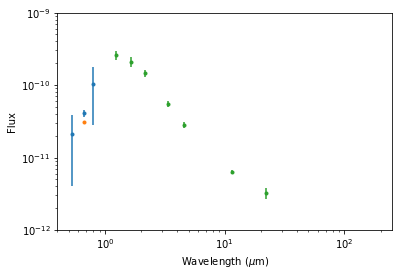

In [10]:
fluxplot_J0949 = plot_fluxdata(subj_J0949)
fluxplot_J0949.show()

Generate the dictionary of models, and from there the list of model combinations.

In [11]:
btsettl_df = pd.read_csv('btsettl_combo_readin_20190315.csv',low_memory=False)

In [12]:
btsettl_models_dict = {}
btsettl_models_combo_dict = {}

#print num_models
#btsettl_data = btsettl_df.values

keylist = []

combo_keylist = []

for i in range(440):
    entry = btsettl_df.loc[i,:]
    print(entry)
    if float(entry['Teff']) > 2400.:
    #print btsettl_data[i,0]
    #print btsettl_data[i,1]
    #print btsettl_data[i,2:]
        key = (float(entry['Teff']),float(entry['Logg']))
        keylist.append(key)

        btsettl_models_dict[key] = {'gmag':entry['G2018'],'bpmag':entry['G2018_BP'],'rpmag':entry['G2018_RP'],
                                   'jmag':entry['J'],'hmag':entry['H'],'kmag':entry['K'],'w1mag':entry['W1_W10'],
                                   'w2mag':entry['W2_W10'],'w3mag':entry['W3_W10'],'w4mag':entry['W4_W10']}
        
        pprint(btsettl_models_dict[key])

for key1 in keylist:
    for key2 in keylist:
        combo_keylist.append((key1,key2))
        
print(len(combo_keylist))

Teff        5777.000
Logg           4.440
G2018        -38.580
G2018_BP     -38.257
G2018_RP     -39.065
J            -39.567
H            -39.880
K            -39.952
W1_W10       -39.955
W2_W10       -39.939
W3_W10       -39.976
W4_W10       -39.981
Name: 0, dtype: float64
{'bpmag': -38.257,
 'gmag': -38.58,
 'hmag': -39.88,
 'jmag': -39.567,
 'kmag': -39.952,
 'rpmag': -39.065,
 'w1mag': -39.955,
 'w2mag': -39.939,
 'w3mag': -39.976,
 'w4mag': -39.981}
Teff        1200.000
Logg           3.500
G2018        -27.962
G2018_BP     -21.601
G2018_RP     -29.437
J            -33.280
H            -34.566
K            -35.012
W1_W10       -35.763
W2_W10       -35.946
W3_W10       -37.478
W4_W10       -37.688
Name: 1, dtype: float64
Teff        1200.000
Logg           4.500
G2018        -28.059
G2018_BP     -22.170
G2018_RP     -29.542
J            -33.293
H            -34.549
K            -34.983
W1_W10       -35.477
W2_W10       -36.093
W3_W10       -37.522
W4_W10       -37.687
Name: 2, dty

Teff        2700.000
Logg           4.000
G2018        -33.435
G2018_BP     -30.596
G2018_RP     -34.772
J            -37.264
H            -37.806
K            -38.144
W1_W10       -38.365
W2_W10       -38.637
W3_W10       -32.969
W4_W10       -35.769
Name: 135, dtype: float64
{'bpmag': -30.596,
 'gmag': -33.435,
 'hmag': -37.806,
 'jmag': -37.264,
 'kmag': -38.144,
 'rpmag': -34.772,
 'w1mag': -38.365,
 'w2mag': -38.637,
 'w3mag': -32.969,
 'w4mag': -35.769}
Teff        2700.000
Logg           4.500
G2018        -33.553
G2018_BP     -30.755
G2018_RP     -34.885
J            -37.303
H            -37.867
K            -38.191
W1_W10       -38.402
W2_W10       -38.645
W3_W10       -38.899
W4_W10       -39.005
Name: 136, dtype: float64
{'bpmag': -30.755,
 'gmag': -33.553000000000004,
 'hmag': -37.867,
 'jmag': -37.303000000000004,
 'kmag': -38.191,
 'rpmag': -34.885,
 'w1mag': -38.402,
 'w2mag': -38.645,
 'w3mag': -38.899,
 'w4mag': -39.005}
Teff        2700.000
Logg           5.000
G2018 

 'hmag': -38.402,
 'jmag': -37.812,
 'kmag': -38.664,
 'rpmag': -36.053000000000004,
 'w1mag': -38.821999999999996,
 'w2mag': -39.010999999999996,
 'w3mag': -39.169000000000004,
 'w4mag': -39.264}
Teff        3200.000
Logg           5.500
G2018        -34.929
G2018_BP     -33.335
G2018_RP     -36.084
J            -37.818
H            -38.417
K            -38.672
W1_W10       -38.834
W2_W10       -39.000
W3_W10       -39.168
W4_W10       -39.255
Name: 173, dtype: float64
{'bpmag': -33.335,
 'gmag': -34.929,
 'hmag': -38.417,
 'jmag': -37.818000000000005,
 'kmag': -38.672,
 'rpmag': -36.084,
 'w1mag': -38.834,
 'w2mag': -39.0,
 'w3mag': -39.168,
 'w4mag': -39.255}
Teff        3300.000
Logg           2.500
G2018        -34.587
G2018_BP     -32.682
G2018_RP     -35.808
J            -37.881
H            -38.810
K            -39.005
W1_W10       -38.968
W2_W10       -39.082
W3_W10       -39.217
W4_W10       -39.319
Name: 174, dtype: float64
{'bpmag': -32.681999999999995,
 'gmag': -34.5869999

Name: 204, dtype: float64
{'bpmag': -34.675,
 'gmag': -35.778,
 'hmag': -39.1,
 'jmag': -38.242,
 'kmag': -39.283,
 'rpmag': -36.771,
 'w1mag': -39.297,
 'w2mag': -39.305,
 'w3mag': -39.435,
 'w4mag': -39.493}
Teff        3700.000
Logg           4.000
G2018        -35.837
G2018_BP     -34.744
G2018_RP     -36.831
J            -38.264
H            -39.034
K            -39.228
W1_W10       -39.267
W2_W10       -39.309
W3_W10       -39.426
W4_W10       -39.487
Name: 205, dtype: float64
{'bpmag': -34.744,
 'gmag': -35.836999999999996,
 'hmag': -39.034,
 'jmag': -38.264,
 'kmag': -39.228,
 'rpmag': -36.830999999999996,
 'w1mag': -39.266999999999996,
 'w2mag': -39.309,
 'w3mag': -39.426,
 'w4mag': -39.486999999999995}
Teff        3700.000
Logg           4.500
G2018        -35.930
G2018_BP     -34.883
G2018_RP     -36.905
J            -38.270
H            -38.948
K            -39.165
W1_W10       -39.247
W2_W10       -39.315
W3_W10       -39.432
W4_W10       -39.495
Name: 206, dtype: float64


Teff        4300.000
Logg           2.500
G2018        -36.943
G2018_BP     -36.295
G2018_RP     -37.696
J            -38.704
H            -39.387
K            -39.535
W1_W10       -39.574
W2_W10       -39.501
W3_W10       -39.628
W4_W10       -39.642
Name: 244, dtype: float64
{'bpmag': -36.295,
 'gmag': -36.943000000000005,
 'hmag': -39.387,
 'jmag': -38.704,
 'kmag': -39.535,
 'rpmag': -37.696,
 'w1mag': -39.574,
 'w2mag': -39.501,
 'w3mag': -39.628,
 'w4mag': -39.641999999999996}
Teff        4300.000
Logg           3.000
G2018        -36.942
G2018_BP     -36.279
G2018_RP     -37.706
J            -38.714
H            -39.403
K            -39.547
W1_W10       -39.582
W2_W10       -39.511
W3_W10       -39.634
W4_W10       -39.647
Name: 245, dtype: float64
{'bpmag': -36.279,
 'gmag': -36.942,
 'hmag': -39.403,
 'jmag': -38.714,
 'kmag': -39.547,
 'rpmag': -37.705999999999996,
 'w1mag': -39.582,
 'w2mag': -39.510999999999996,
 'w3mag': -39.634,
 'w4mag': -39.647}
Teff        4300.000
Log

 'rpmag': -38.175,
 'w1mag': -39.704,
 'w2mag': -39.65,
 'w3mag': -39.738,
 'w4mag': -39.749}
Teff        4700.000
Logg           4.500
G2018        -37.503
G2018_BP     -36.961
G2018_RP     -38.182
J            -39.009
H            -39.576
K            -39.688
W1_W10       -39.707
W2_W10       -39.655
W3_W10       -39.740
W4_W10       -39.750
Name: 276, dtype: float64
{'bpmag': -36.961,
 'gmag': -37.503,
 'hmag': -39.576,
 'jmag': -39.009,
 'kmag': -39.688,
 'rpmag': -38.181999999999995,
 'w1mag': -39.707,
 'w2mag': -39.655,
 'w3mag': -39.74,
 'w4mag': -39.75}
Teff        4700.000
Logg           5.000
G2018        -37.502
G2018_BP     -36.951
G2018_RP     -38.189
J            -39.014
H            -39.581
K            -39.693
W1_W10       -39.711
W2_W10       -39.658
W3_W10       -39.740
W4_W10       -39.751
Name: 277, dtype: float64
{'bpmag': -36.951,
 'gmag': -37.501999999999995,
 'hmag': -39.580999999999996,
 'jmag': -39.014,
 'kmag': -39.693000000000005,
 'rpmag': -38.189,
 'w1mag'

{'bpmag': -37.64,
 'gmag': -38.065,
 'hmag': -39.736,
 'jmag': -39.302,
 'kmag': -39.826,
 'rpmag': -38.646,
 'w1mag': -39.834,
 'w2mag': -39.797,
 'w3mag': -39.853,
 'w4mag': -39.861}
Teff        5200.000
Logg           5.500
G2018        -38.067
G2018_BP     -37.636
G2018_RP     -38.654
J            -39.308
H            -39.743
K            -39.832
W1_W10       -39.839
W2_W10       -39.800
W3_W10       -39.852
W4_W10       -39.859
Name: 313, dtype: float64
{'bpmag': -37.635999999999996,
 'gmag': -38.067,
 'hmag': -39.743,
 'jmag': -39.308,
 'kmag': -39.832,
 'rpmag': -38.654,
 'w1mag': -39.839,
 'w2mag': -39.8,
 'w3mag': -39.852,
 'w4mag': -39.859}
Teff        5300.000
Logg           2.500
G2018        -38.141
G2018_BP     -37.738
G2018_RP     -38.701
J            -39.332
H            -39.722
K            -39.814
W1_W10       -39.830
W2_W10       -39.792
W3_W10       -39.861
W4_W10       -39.869
Name: 314, dtype: float64
{'bpmag': -37.738,
 'gmag': -38.141,
 'hmag': -39.722,
 'jmag':

 'kmag': -39.926,
 'rpmag': -39.003,
 'w1mag': -39.929,
 'w2mag': -39.909,
 'w3mag': -39.95,
 'w4mag': -39.957}
Teff        5700.000
Logg           4.000
G2018        -38.516
G2018_BP     -38.186
G2018_RP     -39.007
J            -39.531
H            -39.858
K            -39.932
W1_W10       -39.934
W2_W10       -39.913
W3_W10       -39.952
W4_W10       -39.958
Name: 345, dtype: float64
{'bpmag': -38.186,
 'gmag': -38.516,
 'hmag': -39.858000000000004,
 'jmag': -39.531,
 'kmag': -39.931999999999995,
 'rpmag': -39.007,
 'w1mag': -39.934,
 'w2mag': -39.913000000000004,
 'w3mag': -39.952,
 'w4mag': -39.958}
Teff        5700.000
Logg           4.500
G2018        -38.516
G2018_BP     -38.184
G2018_RP     -39.009
J            -39.533
H            -39.865
K            -39.937
W1_W10       -39.937
W2_W10       -39.915
W3_W10       -39.953
W4_W10       -39.958
Name: 346, dtype: float64
{'bpmag': -38.184,
 'gmag': -38.516,
 'hmag': -39.865,
 'jmag': -39.533,
 'kmag': -39.937,
 'rpmag': -39.009,


 'hmag': -39.972,
 'jmag': -39.729,
 'kmag': -40.037,
 'rpmag': -39.317,
 'w1mag': -40.032,
 'w2mag': -40.028,
 'w3mag': -40.047,
 'w4mag': -40.051}
Teff        6200.000
Logg           4.500
G2018        -38.903
G2018_BP     -38.643
G2018_RP     -39.321
J            -39.733
H            -39.981
K            -40.044
W1_W10       -40.038
W2_W10       -40.030
W3_W10       -40.048
W4_W10       -40.052
Name: 381, dtype: float64
{'bpmag': -38.643,
 'gmag': -38.903,
 'hmag': -39.981,
 'jmag': -39.733000000000004,
 'kmag': -40.044000000000004,
 'rpmag': -39.321,
 'w1mag': -40.038000000000004,
 'w2mag': -40.03,
 'w3mag': -40.048,
 'w4mag': -40.052}
Teff        6200.000
Logg           5.000
G2018        -38.904
G2018_BP     -38.641
G2018_RP     -39.326
J            -39.736
H            -39.988
K            -40.049
W1_W10       -40.043
W2_W10       -40.033
W3_W10       -40.050
W4_W10       -40.054
Name: 382, dtype: float64
{'bpmag': -38.641,
 'gmag': -38.904,
 'hmag': -39.988,
 'jmag': -39.736,
 

 'w2mag': -40.15,
 'w3mag': -40.15,
 'w4mag': -40.152}
Teff        6900.000
Logg           2.500
G2018        -39.396
G2018_BP     -39.233
G2018_RP     -39.670
J            -39.940
H            -40.066
K            -40.129
W1_W10       -40.128
W2_W10       -40.133
W3_W10       -40.118
W4_W10       -40.094
Name: 426, dtype: float64
{'bpmag': -39.233000000000004,
 'gmag': -39.396,
 'hmag': -40.066,
 'jmag': -39.94,
 'kmag': -40.129,
 'rpmag': -39.67,
 'w1mag': -40.128,
 'w2mag': -40.133,
 'w3mag': -40.118,
 'w4mag': -40.094}
Teff        6900.000
Logg           3.000
G2018        -39.391
G2018_BP     -39.226
G2018_RP     -39.671
J            -39.947
H            -40.077
K            -40.142
W1_W10       -40.137
W2_W10       -40.140
W3_W10       -40.148
W4_W10       -40.160
Name: 427, dtype: float64
{'bpmag': -39.226,
 'gmag': -39.391,
 'hmag': -40.077,
 'jmag': -39.946999999999996,
 'kmag': -40.141999999999996,
 'rpmag': -39.671,
 'w1mag': -40.137,
 'w2mag': -40.14,
 'w3mag': -40.148,
 'w

A function for getting the $\chi^{2}$ for a model fit to a given object.

In [13]:
def get_chi2(mags, magerrs, result_mags):
    chis = np.zeros(mags.size)
    
    for i in range(mags.size):
        chis[i] = ((mags[i] - result_mags[i])**2)/magerrs[i]
        
    sumchis = np.sum(chis)
    
    return sumchis

get_mags: a function for getting the right magnitude information for our data for a given model-combo.

In [14]:
def get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2,filters_used):
    fitmagsfull1 = btsettl_models_dict[(Teff1, logg1)]
    fitmagsfull2 = btsettl_models_dict[(Teff2, logg2)]
    
    #pprint(fitmagsfull1)
    #pprint(fitmagsfull2)
                
    result_mags = []
    
    #gaia_filts = ['gmag1','bpmag1','rpmag1','gmag2','bpmag2','rpmag2']
    
    #remaining_filts = [x for x in filters_used if x not in gaia_filts]
    
    bpflag1 = False
    bpflag2 = False
    
    if 'bpmag1' in filters_used:
        bpflag1 = True
        
    if 'bpmag2' in filters_used:
        bpflag2 = True
        
    #if bpflag1 and bpflag2:
    #    result_mags = np.zeros(13)
    #elif bpflag1 != bpflag2:
    #    result_mags = np.zeros(11)
    #else:
    #    result_mags = np.zeros(9)
    
    #result_mags[0] = fitmagsfull1['gmag'] - (5.*log10rdstar1)
    
    #if bpflag1:
    #    result_mags[1] = fitmagsfull1['bpmag'] - (5.*log10rdstar1)
    #    result_mags[2] = fitmagsfull1['rpmag'] - (5.*log10rdstar1)
    #    result_mags[3] = fitmagsfull2['gmag'] - (5.*log10rdstar2)
    #else:
    #    result_mags[1] = fitmagsfull2['gmag'] - (5.*log10rdstar2)
    
    #if bpflag2:
    #    result_mags[-9] = fitmagsfull2['bpmag'] - (5.*log10rdstar2)
    #    result_mags[-8] = fitmagsfull2['rpmag'] - (5.*log10rdstar2)
    
    result_mags.append(fitmagsfull1['gmag'] - (5.*log10rdstar1))
    if 'bpmag1' in filters_used:
        result_mags.append(fitmagsfull1['bpmag'] - (5.*log10rdstar1))
    if 'rpmag1' in filters_used:
        result_mags.append(fitmagsfull1['rpmag'] - (5.*log10rdstar1))
    result_mags.append(fitmagsfull2['gmag'] - (5.*log10rdstar2))
    if 'bpmag2' in filters_used:
        result_mags.append(fitmagsfull2['bpmag'] - (5.*log10rdstar2))
    if 'rpmag2' in filters_used:
        result_mags.append(fitmagsfull2['rpmag'] - (5.*log10rdstar2))

    filts = ['jmag','hmag','kmag','w1mag','w2mag','w3mag','w4mag']
    
    for filt in filts:
        #filtindex = filts.index(filt)-7
        #print(filt)
        #print(fitmagsfull1[filt])
        #print(fitmagsfull2[filt])
        fitmag1 = fitmagsfull1[filt] - (5.*log10rdstar1)
        fitmag2 = fitmagsfull2[filt] - (5.*log10rdstar2)
        #print(fitmag1, fitmag2)
        #print((10.**(-0.4*fitmag1)), (10.**(-0.4*fitmag2)))
        #print((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2)))
        #print(-2.5*np.log10((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2))))
        #result_mags[filtindex] = (-2.5*np.log10((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2))))
        result_mags.append((-2.5*np.log10((10.**(-0.4*fitmag1)) + (10.**(-0.4*fitmag2)))))
            
    #result_mags_use = np.array(result_mags)
    #print(result_mags_use)
    
    return result_mags

lnlike_rdstar: a function for actually doing the fitting, given magnitude data, a model-combo, and a filter limit.

In [15]:
def lnlike_rdstar(theta, mags, magerrs, Teff1, logg1, Teff2, logg2, filters_used, filter_cut):
    log10rdstar1 = theta[0]
    log10rdstar2 = theta[1]
    

    result_mags = get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2, filters_used)
    
    result_mags_use = result_mags[:filter_cut]
    
    #print(mags.size, result_mags_use.size)
                 
    inv_sigma2 = 1./(magerrs**2)
                
    return -0.5*np.sum((((mags - result_mags_use)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))
    
nll1 = lambda *args: -lnlike_rdstar(*args)


star_fitter_models: cycling through all the model-combos in a reasonable range to find the best possible fit for the given data.

In [16]:
def star_fitter_models(subj, guess, filter_cut):
    fit_results_dict_keys = []
    
    fit_results_dict = {key: None for key in combo_keylist}
    fit_chi_dict = {key: None for key in combo_keylist}
    
    Teff_guess1 = guess[0]
    #Teff_guess1 = 10.**log10Teff_guess1
    
    if Teff_guess1 < 4000.:
        difTeffguess1 = Teff_guess1 - 2500.
        maxdifTeffguess1 = Teff_guess1 + difTeffguess1
        mindifTeffguess1 = 2500.
    else:
        difTeffguess1 = 7000. - Teff_guess1
        mindifTeffguess1 = Teff_guess1 - difTeffguess1
        maxdifTeffguess1 = 7000.
        
    log10rdstar1_guess = guess[1]
    
    Teff_guess2 = guess[2]
    #Teff_guess2 = 10.**log10Teff_guess2
    
    if Teff_guess2 < 4000.:
        difTeffguess2 = Teff_guess2 - 2500.
        maxdifTeffguess2 = Teff_guess2 + difTeffguess2
        mindifTeffguess2 = 2500.
    else:
        difTeffguess2 = 7000. - Teff_guess2
        mindifTeffguess2 = Teff_guess2 - difTeffguess2
        maxdifTeffguess2 = 7000.
    
    log10rdstar2_guess = guess[3]
    
    mags = []
    magerrs = []
    
    #filts_used = subj.filters_used[:filter_cut]
    
    for obsfilt in subj.filters_used:
        mags.append(subj.mags[obsfilt])
        magerrs.append(subj.magerrs[obsfilt])
        
    mags_use = np.array(mags)[:filter_cut]
    magerrs_use = np.array(magerrs)[:filter_cut]
    
    keys_use = []
    
    counter = 0
    loop_start_time = time.time()
    
    for model_combo in combo_keylist:
        Teff1 = model_combo[0][0]
        logg1 = model_combo[0][1]

        Teff2 = model_combo[1][0]
        logg2 = model_combo[1][1]
        
        if (Teff1 > mindifTeffguess1) and (Teff1 < maxdifTeffguess1) and (Teff2 > mindifTeffguess2) and (Teff2 < maxdifTeffguess2):
            keys_use.append(model_combo)
            
            #print(log10rdstar1_guess, log10rdstar2_guess, Teff1, logg1, Teff2, logg2)
            
            result1 = minimize(nll1,[log10rdstar1_guess,log10rdstar2_guess],args=(mags_use,magerrs_use,Teff1,logg1,Teff2,logg2,
                                                              subj.filters_used, filter_cut))
        
            log10rdstar1_opt = result1["x"][0]
            log10rdstar2_opt = result1["x"][1]
            
            #print(log10rdstar1_opt, log10rdstar2_opt)
        
            #fit_mags_full = btsettl_models_dict[(Teff, logg)]
            
            #print Teff, logg, log10rdstar_opt
            #print fit_mags_full
            
            #fit_mags_use = []
            
            #for i in range(len(centwavs)):
            #    fit_mags_use.append(fit_mags_full[cent_wavs_dict[centwavs[i]]])
                
            fit_result_mags = get_mags(log10rdstar1_opt,log10rdstar2_opt,Teff1,logg1,Teff2,logg2,subj.filters_used)
            
            #print Teff, logg, log10rdstar_opt
            #print fit_result_mags
            #print mags
            
            fit_results_dict[model_combo] = (log10rdstar1_opt, log10rdstar2_opt)
            fit_chi_dict[model_combo] = get_chi2(mags_use, magerrs_use, fit_result_mags)
            
            #print fit_chi_dict[model]
        current_time = time.time()
        counter += 1
        if counter%1000 < 1:
            print(counter, model_combo, current_time-loop_start_time, (current_time-loop_start_time)/counter,
                  ((current_time-loop_start_time)/counter)*float(len(combo_keylist)-counter))
    
    fit_chi_dict_use = {x: fit_chi_dict[x] for x in keys_use}
    fit_results_dict_use = {x: fit_results_dict[x] for x in keys_use}
    
    fit_chi_dict_use_values = list(fit_chi_dict_use.values())
    
    minchi = min(fit_chi_dict_use_values)
    
    
    
    best_model = list(fit_chi_dict_use.keys())[fit_chi_dict_use_values.index(minchi)]
    #print(best_model)
    
    best_logrdstars = (fit_results_dict_use[best_model])
    #print(best_logrdstars)
    
    return (best_model[0], best_model[1], best_logrdstars[0], best_logrdstars[1])

plotting_logx_vec = np.linspace(np.log10(0.25), np.log10(2000.), 2001)
plotting_x_vec = np.zeros(2001)
    
for i in range(2001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

get_fit_nuFnus: a function to convert the best fit magnitudes into nuFnu data.

In [17]:
def get_fit_nuFnus(params1,params2,log10rdstar1,log10rdstar2,filters_used):
    Teff1 = params1[0]
    logg1 = params1[1]

    Teff2 = params2[0]
    logg2 = params2[1]
    
    result_mags = get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2,filters_used)
    #print(result_mags)
    result_nuFnu_list = []
    result_centwav_list = []
    
    for filt in filters_used:
        filt_index = filters_used.index(filt)
        if filt[-1] != 'g':
            filt_use = filt[:-1]
        else:
            filt_use = filt
        nuFnu, nuFnu_err, centwav= get_nuFnu(filt_use, result_mags[filt_index], result_mags[filt_index])
        result_nuFnu_list.append(nuFnu)
        result_centwav_list.append(centwav)

    return np.array(result_nuFnu_list), np.array(result_centwav_list)

get_star_fit: A function that gets the best fit pair of stellar models for an object.

In [18]:
def get_star_fit(subj,guesstemp1,guesstemp2,useguesses):
    if 'bpmag2' in subj.filters_used:
        filter_cut = -6
    else:
        filter_cut = -5
        
    first_fit_start_time = time.time()
    print('Beginning first fit at',first_fit_start_time)
    initial_fit = star_fitter_models(subj, [guesstemp1,-10.5,guesstemp2,-10.5], filter_cut)
    first_fit_end_time = time.time()
    result_fit_nuFnus, result_centwavs = get_fit_nuFnus(initial_fit[0],initial_fit[1],initial_fit[2],initial_fit[3],subj.filters_used)
    print(result_fit_nuFnus)
    print(subj.nuFnu_vec)
    print(((subj.nuFnu_vec - result_fit_nuFnus)/subj.nuFnuerr_vec))
    use_next = ((subj.nuFnu_vec[filter_cut] - result_fit_nuFnus[filter_cut])/subj.nuFnuerr_vec[filter_cut]) < 10.
    best_guess = [initial_fit[0][0],initial_fit[2],initial_fit[1][0],initial_fit[3]]
    print(best_guess)
    model1 = initial_fit[0]
    model2 = initial_fit[1]
        
    print('Initial fit complete. Teff1=',model1[0],',Teff2=',model2[0],'. Elapsed time:',
          first_fit_end_time - first_fit_start_time)
    
    while use_next:
        filter_cut += 1
        new_fit_start_time = time.time()
        print('Adding filter. New filter_cut is',filter_cut,'. Start time is',new_fit_start_time)
        if useguesses:
            best_guess = [guesstemp1, initial_fit[2], guesstemp2, initial_fit[3]]
        new_fit = star_fitter_models(subj, best_guess, filter_cut)
        new_fit_end_time = time.time()
        model1 = new_fit[0]
        model2 = new_fit[1]
        best_guess = [model1[0],new_fit[2],model2[0],new_fit[3]]
        print(best_guess)
        result_fit_nuFnus, result_centwavs = get_fit_nuFnus(new_fit[0],new_fit[1],new_fit[2],new_fit[3],subj.filters_used)
        print('Result:',result_fit_nuFnus)
        print('Observed:',subj.nuFnu_vec)
        print('Sigmas:',((subj.nuFnu_vec - result_fit_nuFnus)/subj.nuFnuerr_vec))
        print('New fit complete. Teff1=',model1[0],',Teff2=',model2[0],'. Fit elapsed time is',new_fit_end_time-new_fit_start_time)

        print((((subj.nuFnu_vec[filter_cut] - result_fit_nuFnus[filter_cut])/subj.nuFnuerr_vec[filter_cut])))
        if (((subj.nuFnu_vec[filter_cut] - result_fit_nuFnus[filter_cut])/subj.nuFnuerr_vec[filter_cut]) > 10.) or (filter_cut > -3):
            use_next = False
        print('use_next:',use_next)

    subj.Teff1guess = model1[0]
    subj.logg1_guess = model1[1]
    subj.log10rdstar1_guess = best_guess[1]
    
    subj.Teff2guess = model2[0]
    subj.logg2_guess = model2[1]
    subj.log10rdstar2_guess = best_guess[3]
    
    print('Final guess:',best_guess)
    
    subj.filter_cut = filter_cut
    subj.num_excesses =(-1*filter_cut)
    
    subj.nuFnu_stellar_component, result_centwavs = get_fit_nuFnus(model1, model2, best_guess[1], best_guess[3], subj.filters_used)
    
    teffpull1 = '0'+str(int(model1[0]/100.))
    loggpull1 = str(model1[1])
    
    spectFile1 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull1+'.0-'+loggpull1+'-0.0a+0.0.BT-Settl.spec.7'
    spec_X1, spec_S1, spec_dict1 = fluxdrive_plot(spectFile1,1)
    print(best_guess[0],10.**(best_guess[1]))
    flux_spec_S1 = spec_X1 * spec_S1 * ((10**(best_guess[1]))**2)
    
    subj.den1 = np.trapz(spec_S1*((10**(best_guess[1]))**2),spec_X1)
    
    teffpull2 = '0'+str(int(model2[0]/100.))
    loggpull2 = str(model2[1])
    
    spectFile2 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull2+'.0-'+loggpull2+'-0.0a+0.0.BT-Settl.spec.7'
    spec_X2, spec_S2, spec_dict2 = fluxdrive_plot(spectFile2,1)
    flux_spec_S2 = spec_X2 * spec_S2 * ((10**(best_guess[3]))**2)
    
    spec_X2_int = np.array([x for x in spec_X2 if x<10000000.])
    spec_S2_int = np.array([spec_S2[i] for i in range(spec_X2.size) if spec_X2[i]<10000000.])
    
    subj.den2 = np.trapz(spec_S2_int*((10**(best_guess[3]))**2),spec_X2_int)
    
    subj.den = subj.den1 + subj.den2
    
    subj.nuFnu_star1_plotting_temp = np.interp(plotting_xvec_angstroms, spec_X1, flux_spec_S1)
    subj.nuFnu_star2_plotting_temp = np.interp(plotting_xvec_angstroms, spec_X2, flux_spec_S2)
    subj.nuFnu_starcombined_plotting_temp = subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp
    
    return subj

In [19]:
start_time = time.time()

print('J0949:')
print('Start time:',start_time)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    subj_J0949_with_stellar_fit = get_star_fit(subj_J0949,3000.,3200.,True)
    
end_time = time.time()
print('End time:',end_time)
print('Elapsed time:',end_time-start_time)

start_time = time.time()

print('\nJ0446')
print('Start time:',start_time)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")    
    subj_J0446_with_stellar_fit = get_star_fit(subj_J0446,2800.,2800.,True)
    
end_time = time.time()
print('End time:',end_time)
print('Elapsed time:',end_time-start_time)

J0949:
Start time: 1565112710.4931931
Beginning first fit at 1565112710.4931931
1000 ((2500.0, 3.5), (2900.0, 3.0)) 0.0 0.0 0.0
2000 ((2500.0, 5.0), (3300.0, 4.5)) 0.0 0.0 0.0
3000 ((2600.0, 3.0), (3800.0, 2.5)) 4.901213645935059 0.0016337378819783529 165.54502584298453
4000 ((2600.0, 4.5), (4200.0, 4.0)) 10.838436603546143 0.0027096091508865354 271.8523764992952
5000 ((2700.0, 2.5), (4600.0, 5.5)) 16.277459859848022 0.0032554919719696043 323.3647620837688
6000 ((2700.0, 4.0), (5100.0, 3.5)) 22.69367742538452 0.0037822795708974204 371.90776792677246
7000 ((2700.0, 5.5), (5500.0, 5.0)) 32.29037261009216 0.004612910372870309 448.9699536810943
8000 ((2800.0, 3.5), (6000.0, 3.0)) 38.97679257392883 0.004872099071741104 469.3244314817488
9000 ((2800.0, 5.0), (6400.0, 4.5)) 46.75262475013733 0.005194736083348592 495.20899608953795
10000 ((2900.0, 3.0), (6900.0, 2.5)) 52.96948528289795 0.005296948528289795 499.65585772504807
11000 ((2900.0, 5.0), (2700.0, 3.5)) 60.17276692390442 0.005470251538

3000 ((2600.0, 3.0), (3800.0, 2.5)) 4.263051986694336 0.001421017328898112 143.9902649199168
4000 ((2600.0, 4.5), (4200.0, 4.0)) 10.178698778152466 0.0025446746945381165 255.3046674283147
5000 ((2700.0, 2.5), (4600.0, 5.5)) 15.37629508972168 0.003075259017944336 305.46240299339297
6000 ((2700.0, 4.0), (5100.0, 3.5)) 21.878648042678833 0.003646441340446472 358.55093056476113
7000 ((2700.0, 5.5), (5500.0, 5.0)) 31.41698980331421 0.004488141400473458 436.82631436668123
8000 ((2800.0, 3.5), (6000.0, 3.0)) 36.91786861419678 0.004614733576774597 444.53267071712014
9000 ((2800.0, 5.0), (6400.0, 4.5)) 44.40366339683533 0.0049337403774261475 470.3285364396572
10000 ((2900.0, 3.0), (6900.0, 2.5)) 50.86122393608093 0.005086122393608093 479.76883926665784
11000 ((2900.0, 5.0), (2700.0, 3.5)) 57.031211376190186 0.005184655579653653 483.87872059349576
12000 ((3000.0, 3.0), (3100.0, 5.0)) 63.06282305717468 0.005255235254764557 485.2106158371568
13000 ((3000.0, 4.5), (3600.0, 3.0)) 69.05617880821228 0

3000 ((2600.0, 3.0), (3800.0, 2.5)) 3.6709635257720947 0.0012236545085906982 123.99168770098686
4000 ((2600.0, 4.5), (4200.0, 4.0)) 9.068737268447876 0.002267184317111969 227.46433535152673
5000 ((2700.0, 2.5), (4600.0, 5.5)) 14.198665618896484 0.002839733123779297 282.06785145187376
6000 ((2700.0, 4.0), (5100.0, 3.5)) 19.6301748752594 0.003271695812543233 321.70257755156354
7000 ((2700.0, 5.5), (5500.0, 5.0)) 24.742859363555908 0.0035346941947937013 344.0282512850761
8000 ((2800.0, 3.5), (6000.0, 3.0)) 29.793720245361328 0.003724215030670166 358.74990968942643
9000 ((2800.0, 5.0), (6400.0, 4.5)) 35.154717445373535 0.003906079716152615 372.3626732611126
10000 ((2900.0, 3.0), (6900.0, 2.5)) 40.45331811904907 0.004045331811904907 381.59210448517797
11000 ((2900.0, 5.0), (2700.0, 3.5)) 46.48498749732971 0.004225907954302701 394.3997634671168
12000 ((3000.0, 3.0), (3100.0, 5.0)) 52.33187460899353 0.004360989550749461 402.64580423114694
13000 ((3000.0, 4.5), (3600.0, 3.0)) 58.43533992767334

3000 ((2600.0, 3.0), (3800.0, 2.5)) 4.3675620555877686 0.0014558540185292562 147.520231843551
4000 ((2600.0, 4.5), (4200.0, 4.0)) 10.77035641670227 0.0026925891041755675 270.1447722328305
5000 ((2700.0, 2.5), (4600.0, 5.5)) 18.21431851387024 0.003642863702774048 361.8420087328434
6000 ((2700.0, 4.0), (5100.0, 3.5)) 25.880787134170532 0.004313464522361756 424.13865301930906
7000 ((2700.0, 5.5), (5500.0, 5.0)) 32.06614804267883 0.004580878291811262 445.8523032636983
8000 ((2800.0, 3.5), (6000.0, 3.0)) 37.627806663513184 0.004703475832939148 453.0811235111952
9000 ((2800.0, 5.0), (6400.0, 4.5)) 43.66581416130066 0.004851757129033406 462.51315535362556
10000 ((2900.0, 3.0), (6900.0, 2.5)) 50.29799270629883 0.005029799270629883 474.45593539924624
11000 ((2900.0, 5.0), (2700.0, 3.5)) 56.830546855926514 0.005166413350538774 482.17619159243327
12000 ((3000.0, 3.0), (3100.0, 5.0)) 64.1136212348938 0.0053428017695744835 493.2955445830425
13000 ((3000.0, 4.5), (3600.0, 3.0)) 71.66443848609924 0.0

3400.0 1.3993161389598684e-10
End time: 1565113243.7620726
Elapsed time: 533.2688794136047

J0446
Start time: 1565113243.7620726
Beginning first fit at 1565113243.7620726
1000 ((2500.0, 3.5), (2900.0, 3.0)) 0.0 0.0 0.0
2000 ((2500.0, 5.0), (3300.0, 4.5)) 0.0 0.0 0.0
3000 ((2600.0, 3.0), (3800.0, 2.5)) 0.8646793365478516 0.0002882264455159505 29.205697497685748
4000 ((2600.0, 4.5), (4200.0, 4.0)) 1.8359262943267822 0.00045898157358169556 46.049162295877935
5000 ((2700.0, 2.5), (4600.0, 5.5)) 2.707031011581421 0.0005414062023162842 53.777336669874195
6000 ((2700.0, 4.0), (5100.0, 3.5)) 3.671976327896118 0.000611996054649353 60.176960057616235
7000 ((2700.0, 5.5), (5500.0, 5.0)) 5.060011148452759 0.0007228587354932512 70.35511786682265
8000 ((2800.0, 3.5), (6000.0, 3.0)) 6.379145383834839 0.0007973931729793549 76.81208695992828
9000 ((2800.0, 5.0), (6400.0, 4.5)) 7.920891523361206 0.0008800990581512451 83.89896311450003
10000 ((2900.0, 3.0), (6900.0, 2.5)) 9.640815019607544 0.000964081501

3000 ((2600.0, 3.0), (3800.0, 2.5)) 0.9712522029876709 0.00032375073432922366 32.805338158845906
4000 ((2600.0, 4.5), (4200.0, 4.0)) 2.5751571655273438 0.000643789291381836 64.59073581504822
5000 ((2700.0, 2.5), (4600.0, 5.5)) 4.163403272628784 0.0008326806545257569 82.70933673338891
6000 ((2700.0, 4.0), (5100.0, 3.5)) 6.812028646469116 0.0011353381077448526 111.6366607964436
7000 ((2700.0, 5.5), (5500.0, 5.0)) 9.95759105682373 0.0014225130081176758 138.45176856708528
8000 ((2800.0, 3.5), (6000.0, 3.0)) 12.06329607963562 0.0015079120099544526 145.25565600690246
9000 ((2800.0, 5.0), (6400.0, 4.5)) 14.547639846801758 0.0016164044274224174 154.09021766175164
10000 ((2900.0, 3.0), (6900.0, 2.5)) 17.156432628631592 0.0017156432628631592 161.83491334261893
11000 ((2900.0, 5.0), (2700.0, 3.5)) 19.454654693603516 0.001768604972145774 165.06213344539296
12000 ((3000.0, 3.0), (3100.0, 5.0)) 21.861014366149902 0.0018217511971791586 168.20046628435452
13000 ((3000.0, 4.5), (3600.0, 3.0)) 24.297915

3000 ((2600.0, 3.0), (3800.0, 2.5)) 1.7975809574127197 0.0005991936524709065 60.71569361122449
4000 ((2600.0, 4.5), (4200.0, 4.0)) 7.118070602416992 0.001779517650604248 178.5372263674736
5000 ((2700.0, 2.5), (4600.0, 5.5)) 10.152829885482788 0.0020305659770965575 201.69408793902397
6000 ((2700.0, 4.0), (5100.0, 3.5)) 12.337242603302002 0.0020562071005503337 202.18478799001377
7000 ((2700.0, 5.5), (5500.0, 5.0)) 14.770150899887085 0.0021100215571267264 205.36628813358715
8000 ((2800.0, 3.5), (6000.0, 3.0)) 16.69529151916504 0.00208691143989563 201.03009209370612
9000 ((2800.0, 5.0), (6400.0, 4.5)) 19.283533573150635 0.0021426148414611817 204.253330221653
10000 ((2900.0, 3.0), (6900.0, 2.5)) 21.55606770515442 0.002155606770515442 203.33623105595112
11000 ((2900.0, 5.0), (2700.0, 3.5)) 23.791234493255615 0.002162839499386874 201.85564763827756
12000 ((3000.0, 3.0), (3100.0, 5.0)) 26.34177827835083 0.0021951481898625693 202.67583722182115
13000 ((3000.0, 4.5), (3600.0, 3.0)) 28.4943914413

3000.0 1.591134797117027e-10
End time: 1565113333.8806286
Elapsed time: 90.11855602264404


In [ ]:
def plot_starfit_data(subj):
    fig = plt.figure()
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp,':',color='gray')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star2_plotting_temp,'--',color='silver')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp)
    plt.errorbar(subj.centwav_vec1, subj.nuFnu_vec1, yerr=5.*subj.nuFnuerr_vec1,fmt='o')
    plt.errorbar(subj.centwav_vec2, subj.nuFnu_vec2, yerr=5.*subj.nuFnuerr_vec2,fmt='o')
    plt.errorbar(subj.centwav_vec_combined, subj.nuFnu_vec_combined, yerr=5.*subj.nuFnuerr_vec_combined,fmt='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Wavelength ($\mu$m)')
    plt.ylabel(r'Flux')
    plt.xlim([0.4,250.])

    min_nuFnu_logs = min(np.log10(subj.nuFnu_vec))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_vec))

    ymin = (float(np.floor((min_nuFnu_logs-0.5)*2.))/2.)-0.5
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    print(ymin,ymax)

    plt.ylim([10**ymin,10**ymax])
    return fig


In [ ]:
%matplotlib notebook

fig_J0949_starfit = plot_starfit_data(subj_J0949_with_stellar_fit)
fig_J0949_starfit.show()

fig_J0446_starfit = plot_starfit_data(subj_J0446_with_stellar_fit)
fig_J0446_starfit.show()

In [ ]:
print(subj_J0949_with_stellar_fit.den1, subj_J0949_with_stellar_fit.den2, subj_J0949_with_stellar_fit.den)
print(subj_J0446_with_stellar_fit.den1, subj_J0446_with_stellar_fit.den2, subj_J0446_with_stellar_fit.den)

In [ ]:
def get_disk_model(theta, nuFnu, nuFnuerrs, filters_used, Teff1, logg1, Teff2, logg2,log10rdstar1,log10rdstar2):
    log10Tdisk, log10xdisk = theta
    
    rdstar1 = 10.**log10rdstar1
    rdstar2 = 10.**log10rdstar2
    Tdisk = 10.**log10Tdisk
    xdisk = 10.**log10xdisk
    
    stellar_mags = get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2, filters_used)

    stellar_nuFnus, centwavs = get_fit_nuFnus((Teff1,logg1),(Teff2,logg2),log10rdstar1,log10rdstar2,filters_used)
    
    centwavs_angstroms = centwavs *1.0e4 * u.AA
    
    flux_disk_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr    
    flux_disk_lam = flux_disk_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    disk_model = flux_disk_lam * xdisk
    
    model = stellar_nuFnus + disk_model        
    return model

In [ ]:
def get_two_disk_model(theta, nuFnu, nuFnuerrs, filters_used, Teff1, logg1, Teff2, logg2,log10rdstar1,log10rdstar2):
    log10Tdisk1, log10xdisk1, log10Tdisk2, log10xdisk2 = theta
    
    rdstar1 = 10.**log10rdstar1
    rdstar2 = 10.**log10rdstar2
    Tdisk1 = 10.**log10Tdisk1
    xdisk1 = 10.**log10xdisk1
    Tdisk2 = 10.**log10Tdisk2
    xdisk2 = 10.**log10xdisk2
    
    stellar_mags = get_mags(log10rdstar1, log10rdstar2, Teff1, logg1, Teff2, logg2, filters_used)

    stellar_nuFnus, centwavs = get_fit_nuFnus((Teff1,logg1),(Teff2,logg2),log10rdstar1,log10rdstar2,filters_used)
    
    centwavs_angstroms = centwavs *1.0e4 * u.AA
    
    flux_disk1_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk1*u.K) * np.pi * u.sr    
    flux_disk1_lam = flux_disk1_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg

    flux_disk2_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk2*u.K) * np.pi * u.sr    
    flux_disk2_lam = flux_disk1_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    disk_model = (flux_disk1_lam * xdisk1) + (flux_disk2_lam * xdisk2)
    
    model = stellar_nuFnus + disk_model        
    return model

In [ ]:
def lnlike_models(theta, nuFnu, nuFnuerrs, filters_used, Teff1, logg1, Teff2, logg2,log10rdstar1,log10rdstar2):
    if len(theta) > 2:
        model = get_two_disk_model(theta, nuFnu, nuFnuerrs, filters_used, Teff1, logg1, Teff2, logg2,log10rdstar1,log10rdstar2)
    else:
        model = get_disk_model(theta, nuFnu, nuFnuerrs, filters_used, Teff1, logg1, Teff2, logg2,log10rdstar1,log10rdstar2)
    inv_sigma2 = 1./(nuFnuerrs**2)                
    return -0.5*np.sum((((nuFnu - model)**2)*inv_sigma2) + np.log(2.*np.pi) - np.log(inv_sigma2))

nllmodels = lambda *args: -lnlike_models(*args)

In [ ]:
wien_lamFlam_x = 3.90269

wien_lamFlam_factor = (h*c)/(wien_lamFlam_x*k)

sb_sigma = ((2.*(np.pi**5)*(k**4))/(15.*(h**3)*(c**2))) * 1000.

In [ ]:
def get_disk_fit(subj):
    print("Excesses:", subj.num_excesses)
    subj.good_disk_fit = False
        
    #Define a vector of Tdisk guesses
    Tdiskvals = np.linspace(30., 300., 11)
        
    #Also create a dictionary to store xdiskval vectors
    xdiskvals_dict = {x: None for x in Tdiskvals}
        
    #ALSO create dictionaries to store results and negative log likelihoods
    val_chi_dict = {}
    val_results_dict = {}
        
    minimization_start = time.time()
    
    maxrdstar = 10.**(max(subj.log10rdstar1_guess, subj.log10rdstar2_guess))
    minrdstar = 10.**(min(subj.log10rdstar1_guess, subj.log10rdstar2_guess))
    
    maxTeff = max(subj.Teff1guess, subj.Teff2guess)
    minTeff = min(subj.Teff1guess, subj.Teff2guess)
        
    for Tdiskval in Tdiskvals:
        #Define possible xdisk guesses based on the Tdisk guess
        xdiskmax = (maxrdstar**2) * 1.e-2 * ((maxTeff/Tdiskval)**4)
        xdiskmin = (minrdstar**2) * 1.e-9 * ((minTeff/Tdiskval)**4)
         
        xdiskvals = np.linspace(xdiskmin, xdiskmax, 11)
            
        xdiskvals_dict[Tdiskval] = xdiskvals    

        for xdiskval in xdiskvals:
            guess = [np.log10(Tdiskval), np.log10(xdiskval)]
            
            #def lnlike_models(theta, nuFnu, nuFnuerrs, filters_used, Teff1, logg1, Teff2, logg2):
            res = get_disk_model(guess, subj.nuFnu_vec, subj.nuFnuerr_vec, subj.filters_used, subj.Teff1guess, 
                                 subj.logg1_guess, subj.Teff2guess, subj.logg2_guess, subj.log10rdstar1_guess, 
                                 subj.log10rdstar2_guess)
            
            reschi = get_chi2(subj.nuFnu_vec, subj.nuFnuerr_vec, res)
                
            val_chi_dict[(Tdiskval, xdiskval)] = reschi

    print("Minimization cycle finished. Time:", time.time() - minimization_start)
                
    sorted_chis = sorted(list(val_chi_dict.values()))
    sorted_keys = []
    #sorted_results = []
    
    for chi in sorted_chis:
        sorted_keys.append(list(val_chi_dict.keys())[list(val_chi_dict.values()).index(chi)])
        #sorted_results.append(val_results_dict[sorted_keys[-1]])
            
    num_options = len(sorted_chis)
        
    options_tested = 0
        
    fir_test_res = False
    disk_peak_res = False
        
    while not subj.good_disk_fit and options_tested < num_options:
        key = sorted_keys[options_tested]
            
        guess = [np.log10(key[0]), np.log10(key[1])]
            
        result2 = minimize(nllmodels,guess,args = (subj.nuFnu_vec,subj.nuFnuerr_vec,subj.filters_used,subj.Teff1guess,
                                                   subj.logg1_guess, subj.Teff2guess,subj.logg2_guess,
                                                   subj.log10rdstar1_guess,subj.log10rdstar2_guess))

        log10Tdiskres, log10xdiskres = result2["x"]

        Tdisk_test = 10.**(log10Tdiskres)
        xdisk_test = 10.**(log10xdiskres)
            
        if Tdisk_test == 0.0:
            options_tested += 1
            continue
            
            #print options_tested, Tdisk_test, xdisk_test
            
        tdisk_test_res = Tdisk_test < minTeff
            
        if max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp) > 0.:
            peak_star_lamFlam = max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp)
        else:
            peak_star_lambda = wien_lamFlam_factor / Teff_use
            peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)
            #peak_star_lambda = wien_lamFlam_factor / maxTeff
            #peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, maxTeff*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (minrdstar**2)

            
        fir_test = ((Tdisk_test/minTeff)**4) * (xdisk_test/(minrdstar**2))
            
            #print fir_test
            
            #print 'Lir/Lstar test:', fir_test
            
        fir_test_res = (fir_test < 1.)
            
        peak_disk_lambda = (wien_lamFlam_factor / Tdisk_test) * 1.e10
            #print peak_disk_lambda
            
        print('lambda =', peak_disk_lambda, 'Tdisk =', Tdisk_test)
            
        peak_disk_lamFlam = blackbody_lambda(peak_disk_lambda * u.AA, Tdisk_test*u.K) * np.pi * u.sr * (peak_disk_lambda * u.AA) * u.cm * u.cm * u.s / u.erg * xdisk_test

        if max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp) > 0.:
            peak_star_lamFlam = max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp)
        else:
            peak_star_lambda = wien_lamFlam_factor / Teff_use
            peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

            #print 'Disk peak vs star peak:', peak_disk_lamFlam, peak_star_lamFlam
                
        disk_peak_res = (peak_disk_lamFlam < peak_star_lamFlam)
            
        if (disk_peak_res and fir_test_res) or (subj.nuFnu[-1] > peak_star_lamFlam):
            subj.good_disk_fit = True
            subj.log10Tdiskguess = np.log10(Tdisk_test)
            subj.log10xdiskguess = np.log10(xdisk_test)
                #subj.fir = ((subj.Tdisk/subj.Teff)**4) * (subj.xdisk/(subj.rdstar**2))
                
        options_tested += 1
            #print options_tested

    if options_tested == num_options and not subj.good_disk_fit:
        print("Disk fitting failed")
        subj.nuFnu_model_plotting_temp = subj.nuFnu_star_plotting_temp
        return subj
        
    #nuFnu_disk_points_blackbody = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, (10.**subj.log10Tdiskguess * u.K)) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg

    subj.lir_lstar = ((10.**subj.log10xdiskguess)*((10.**subj.log10Tdiskguess)**4)*(sb_sigma))/subj.den
    subj.num_disks = 1.
    
    subj.nuFnu_disk_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdiskguess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg
    subj.nuFnu_model_plotting_temp_blackbody = subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp + subj.nuFnu_disk_plotting_temp_blackbody          

    subj.nuFnu_disk_plotting_temp = subj.nuFnu_disk_plotting_temp_blackbody
    subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_blackbody
    print(10.**subj.log10Tdiskguess, subj.lir_lstar)
    return subj


In [ ]:
disk_start_time1 = time.time()
subj_J0949_with_disk_fit = get_disk_fit(subj_J0949_with_stellar_fit)
print('Done. Time:',time.time()-disk_start_time1)

disk_start_time2 = time.time()
subj_J0446_with_disk_fit = get_disk_fit(subj_J0446_with_stellar_fit)
print('Done. Time:',time.time()-disk_start_time2)

In [ ]:
def plot_fullmodel_data(subj):
    bb1 = 10.**subj.log10Tdiskguess
    
    fig = plt.figure(figsize=(4.5,3.5))
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp,':',color='gray')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star2_plotting_temp,'--',color='silver')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp,color='k')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_model_plotting_temp)
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_disk_plotting_temp,label=(("{:.0f}".format(bb1))+'K blackbody'))
    plt.plot([0.,0.],[0.,0.])
    plt.errorbar(subj.centwav_vec1, subj.nuFnu_vec1, yerr=5.*subj.nuFnuerr_vec1,fmt='o',label='Star 1')
    plt.errorbar(subj.centwav_vec2, subj.nuFnu_vec2, yerr=5.*subj.nuFnuerr_vec2,fmt='o',label='Star 2')
    plt.errorbar(subj.centwav_vec_combined, subj.nuFnu_vec_combined, yerr=5.*subj.nuFnuerr_vec_combined,fmt='o',label='Blended data')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Wavelength ($\mu$m)',fontsize=12)
    plt.ylabel(r'Flux',fontsize=12)
    plt.xlim([0.4,250.])

    min_nuFnu_logs = min(np.log10(subj.nuFnu_vec))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_vec))

    ymin = (float(np.floor((min_nuFnu_logs-0.5)*2.))/2.)-0.5
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    print(ymin,ymax)

    plt.ylim([10**ymin,10**ymax])
    plt.legend(loc='upper right',fontsize=10)
    return fig


In [ ]:
%matplotlib notebook

fig_J0949_diskfit = plot_fullmodel_data(subj_J0949_with_disk_fit)
#fig_J0949_diskfit.show()
fig_J0949_diskfit.savefig('J0949_diskfit.pdf')

#fig_J0446_diskfit = plot_fullmodel_data(subj_J0446_with_disk_fit)
#fig_J0446_diskfit.show()

In [ ]:
def get_two_disk_fit(subj):
    print("Excesses:", subj.num_excesses)
    subj.good_disk_fit = False
        
    #Define a vector of Tdisk guesses
    Tdisk1vals = np.linspace(20., 380., 13.)
    Tdisk2vals = np.linspace(600., 2000., 15.)
        
    #Also create a dictionary to store xdiskval vectors
    xdisk1vals_dict = {x: None for x in Tdisk1vals}
    xdisk2vals_dict = {x: None for x in Tdisk2vals}
        
    #ALSO create dictionaries to store results and negative log likelihoods
    val_chi_dict = {}
    val_results_dict = {}
        
    minimization_start = time.time()

    #for Tdiskval in Tdiskvals:
        #Define possible xdisk guesses based on the Tdisk guess
        #xdiskmax = (maxrdstar**2) * 1.e-2 * ((maxTeff/Tdiskval)**4)
        #xdiskmin = (minrdstar**2) * 1.e-9 * ((minTeff/Tdiskval)**4)
    
    maxrdstar = 10.**(max(subj.log10rdstar1_guess, subj.log10rdstar2_guess))
    minrdstar = 10.**(min(subj.log10rdstar1_guess, subj.log10rdstar2_guess))
    
    maxTeff = max(subj.Teff1guess, subj.Teff2guess)
    minTeff = min(subj.Teff1guess, subj.Teff2guess)
        
    for Tdiskval in Tdisk1vals:
        #Define possible xdisk guesses based on the Tdisk guess
        xdiskmax = (maxrdstar**2) * 1.e-2 * ((maxTeff/Tdiskval)**4)
        xdiskmin = (minrdstar**2) * 1.e-9 * ((minTeff/Tdiskval)**4)
         
        xdiskvals = np.linspace(xdiskmin, xdiskmax, 11)
            
        xdisk1vals_dict[Tdiskval] = xdiskvals    
        
    for Tdiskval in Tdisk2vals:
        xdiskmax = (minrdstar**2) * 1.e-2 * ((maxTeff/Tdiskval)**4)
        xdiskmin = (maxrdstar**2) * 1.e-9 * ((minTeff/Tdiskval)**4)
        
        xdiskvals = np.linspace(xdiskmin, xdiskmax, 11)
            
        xdisk2vals_dict[Tdiskval] = xdiskvals
        
    for Tdisk1val in Tdisk1vals:
        xdisk1vals = xdisk1vals_dict[Tdisk1val]
        
        for Tdisk2val in Tdisk2vals:
            xdisk2vals = xdisk2vals_dict[Tdisk2val]
            
            for xdisk1val in xdisk1vals:
                for xdisk2val in xdisk2vals:
                    guess = [np.log10(Tdisk1val), np.log10(xdisk1val),np.log10(Tdisk2val),np.log10(xdisk2val)]
            

                    res = get_two_disk_model(guess,subj.nuFnu_vec,subj.nuFnuerr_vec,subj.filters_used,subj.Teff1guess, 
                                 subj.logg1_guess, subj.Teff2guess, subj.logg2_guess,subj.log10rdstar1_guess,
                                            subj.log10rdstar2_guess)
            
                    reschi = get_chi2(subj.nuFnu_vec, subj.nuFnuerr_vec, res)
                
                    val_chi_dict[(Tdisk1val, xdisk1val, Tdisk2val, xdisk2val)] = reschi

    print("Minimization cycle finished. Time:", time.time() - minimization_start)
                
    sorted_chis = sorted(list(val_chi_dict.values()))
    sorted_keys = []
    #sorted_results = []
    
    for chi in sorted_chis:
        sorted_keys.append(list(val_chi_dict.keys())[list(val_chi_dict.values()).index(chi)])
        #sorted_results.append(val_results_dict[sorted_keys[-1]])
            
    num_options = len(sorted_chis)
        
    options_tested = 0
        
    fir_test_res = False
    disk_peak_res = False
        
    while not subj.good_disk_fit and options_tested < num_options:
        key = sorted_keys[options_tested]
            
        print(key)
        guess = [np.log10(key[0]), np.log10(key[1]),np.log10(key[2]),np.log10(key[3])]
            
        result2 = minimize(nllmodels,guess,args = (subj.nuFnu_vec,subj.nuFnuerr_vec,subj.filters_used,subj.Teff1guess,
                                                   subj.logg1_guess,subj.Teff2guess,subj.logg2_guess,
                                                   subj.log10rdstar1_guess,subj.log10rdstar2_guess))

        log10Tdisk1res,log10xdisk1res,log10Tdisk2res,log10xdisk2res = result2["x"]

        Tdisk1_test = 10.**(log10Tdisk1res)
        xdisk1_test = 10.**(log10xdisk1res)
        Tdisk2_test = 10.**(log10Tdisk2res)
        xdisk2_test = 10.**(log10xdisk2res)

        
        if Tdisk1_test == 0.0 or Tdisk2_test == 0.0:
            options_tested += 1
            continue
            
            #print options_tested, Tdisk_test, xdisk_test
            
        tdisk_test_res = (Tdisk1_test < minTeff) and (Tdisk2_test < minTeff)
        #tdisk2_test_res = Tdisk2_test < minTeff
        
            
        if max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp) > 0.:
            peak_star_lamFlam = max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp)
        else:
            peak_star_lambda = wien_lamFlam_factor / Teff_use
            peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)
            #peak_star_lambda = wien_lamFlam_factor / maxTeff
            #peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, maxTeff*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (minrdstar**2)

            
        fir_test1 = ((Tdisk1_test/minTeff)**4) * (xdisk1_test/(minrdstar**2))
        fir_test2 = ((Tdisk2_test/minTeff)**4) * (xdisk2_test/(minrdstar**2))
            
            #print fir_test
            
            #print 'Lir/Lstar test:', fir_test
            
        fir_test_res = (fir_test1 < 1.) and (fir_test2 < 1.)
            
        peak_disk_lambda = (wien_lamFlam_factor / max(Tdisk1_test,Tdisk2_test)) * 1.e10
            #print peak_disk_lambda
            
        print('lambda =', peak_disk_lambda, 'Tdisk1 =', Tdisk1_test, 'Tdisk2 =', Tdisk2_test)
            
        peak_disk_lamFlam = blackbody_lambda(peak_disk_lambda * u.AA, max(Tdisk1_test,Tdisk2_test)*u.K) * np.pi * u.sr * (peak_disk_lambda * u.AA) * u.cm * u.cm * u.s / u.erg * max(xdisk1_test, xdisk2_test)

        if max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp) > 0.:
            peak_star_lamFlam = max(subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp)
        else:
            peak_star_lambda = wien_lamFlam_factor / Teff_use
            peak_star_lamFlam = blackbody_lambda(peak_star_lambda * u.m, Teff_use*u.K) * np.pi * u.sr * (peak_star_lambda * u.m) * u.cm * u.cm * u.s / u.erg * (rdstar_use**2)

            #print 'Disk peak vs star peak:', peak_disk_lamFlam, peak_star_lamFlam
                
        disk_peak_res = (peak_disk_lamFlam < peak_star_lamFlam)
        
        #def get_fit_nuFnus(params1,params2,log10rdstar1,log10rdstar2,filters_used):
        
        
        stellar_nuFnus, centwavs = get_fit_nuFnus((subj.Teff1guess,subj.logg1_guess),(subj.Teff2guess,subj.logg2_guess),
                                                  subj.log10rdstar1_guess,subj.log10rdstar2_guess,subj.filters_used)
    
        centwavs_angstroms = centwavs *1.0e4 * u.AA
    
        flux_disk1_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk1_test*u.K) * np.pi * u.sr    
        flux_disk1_lam = flux_disk1_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg #* xdisk1_test

        flux_disk2_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk2_test*u.K) * np.pi * u.sr    
        flux_disk2_lam = flux_disk1_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg #* xdisk2_test
        
        #res_nuFnus, res_nuFnu_centwavs = get_fit_nuFnus([subj.Teff1guess,subj.logg1_guess],[subj.Teff2guess,subj.logg2_guess],
        #                                               subj.log10rdstar1_guess, subj.log10rdstar2_guess,subj.filters_used)
        
        #disk1_nuFnu = blackbody_lambda(res_nuFnu_centwavs*u.micron,Tdisk1_test*u.K) * np.pi * u.sr * (res_nuFnu_centwavs*u.micron) * (10.**subj.log10xdisk1guess) * u.cm * u.cm * u.s / u.erg
        #disk2_nuFnu = blackbody_lambda(res_nuFnu_centwavs*u.micron,Tdisk2_test*u.K) * np.pi * u.sr * (res_nuFnu_centwavs*u.micron) * (10.**subj.log10xdisk2guess) * u.cm * u.cm * u.s / u.erg
        
        model_nuFnu = stellar_nuFnus + (flux_disk1_lam*xdisk1_test) + (flux_disk2_lam*xdisk2_test)
        
        sigmas = (subj.nuFnu_vec - model_nuFnu)/subj.nuFnuerr_vec
        #print(sigmas)
        
        #excesses = len([s for s in sigmas[-4:] if s>10.])
        
        #excess_test = excesses<1
    
            
        if (tdisk_test_res and disk_peak_res and fir_test_res) or (subj.nuFnu_vec[-1] > peak_star_lamFlam):
            subj.good_disk_fit = True
            subj.log10Tdisk1guess = np.log10(Tdisk1_test)
            subj.log10xdisk1guess = np.log10(xdisk1_test)
            subj.log10Tdisk2guess = np.log10(Tdisk2_test)
            subj.log10xdisk2guess = np.log10(xdisk2_test)
                #subj.fir = ((subj.Tdisk/subj.Teff)**4) * (subj.xdisk/(subj.rdstar**2))
                
        
                
        options_tested += 1
        print(options_tested)

    if options_tested == num_options and not subj.good_disk_fit:
        print("Disk fitting failed")
        subj.nuFnu_model_plotting_temp = subj.nuFnu_star_plotting_temp
        return subj
        
    #nuFnu_disk_points_blackbody = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, (10.**subj.log10Tdiskguess * u.K)) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (10.**subj.log10xdiskguess) * u.cm * u.cm * u.s / u.erg

    subj.lir1_lstar = ((10.**subj.log10xdisk1guess)*((10.**subj.log10Tdisk1guess)**4)*sb_sigma)/subj.den
    subj.lir2_lstar = ((10.**subj.log10xdisk1guess)*((10.**subj.log10Tdisk1guess)**4)*sb_sigma)/subj.den
    subj.lir_lstar = subj.lir1_lstar + subj.lir2_lstar
    subj.num_disks = 2
    
    subj.nuFnu_disk1_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdisk1guess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdisk1guess) * u.cm * u.cm * u.s / u.erg
    subj.nuFnu_disk2_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj.log10Tdisk2guess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj.log10xdisk2guess) * u.cm * u.cm * u.s / u.erg
    subj.nuFnu_model_plotting_temp_blackbody = subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp + subj.nuFnu_disk1_plotting_temp_blackbody + subj.nuFnu_disk2_plotting_temp_blackbody          

    subj.nuFnu_disk1_plotting_temp = subj.nuFnu_disk1_plotting_temp_blackbody
    subj.nuFnu_disk2_plotting_temp = subj.nuFnu_disk2_plotting_temp_blackbody
    subj.nuFnu_model_plotting_temp = subj.nuFnu_model_plotting_temp_blackbody
    print(10.**subj.log10Tdisk1guess, 10.**subj.log10Tdisk2guess,subj.lir_lstar)
    return subj


In [ ]:
disk_start_time2_2disks = time.time()
subj_J0446_with_two_disk_fit = get_two_disk_fit(subj_J0446_with_stellar_fit)
print('Done. Time:',time.time()-disk_start_time2_2disks)

In [ ]:
def plot_fullmodel_twodisk_data(subj):
    bb1 = 10.**subj.log10Tdisk1guess
    bb2 = 10.**subj.log10Tdisk2guess
    
    fig = plt.figure(figsize=(4.5,3.5))
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp,':',color='gray')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star2_plotting_temp,'--',color='silver')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp,'k')
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_model_plotting_temp)
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_disk1_plotting_temp,label=(("{:.0f}".format(bb1))+'K blackbody'))
    plt.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_disk2_plotting_temp,label=(("{:.0f}".format(bb2))+'K blackbody'))
    plt.errorbar(subj.centwav_vec1, subj.nuFnu_vec1, yerr=5.*subj.nuFnuerr_vec1,fmt='o',label='Star 1')
    plt.errorbar(subj.centwav_vec2, subj.nuFnu_vec2, yerr=5.*subj.nuFnuerr_vec2,fmt='o',label='Star 2')
    plt.errorbar(subj.centwav_vec_combined, subj.nuFnu_vec_combined, yerr=5.*subj.nuFnuerr_vec_combined,fmt='o',label='Blended data')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Wavelength ($\mu$m)',fontsize=12)
    plt.ylabel(r'Flux',fontsize=12)
    plt.xlim([0.4,250.])

    min_nuFnu_logs = min(np.log10(subj.nuFnu_vec))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_vec))

    ymin = (float(np.floor((min_nuFnu_logs-0.5)*2.))/2.)-0.5
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.
    print(ymin,ymax)

    plt.ylim([10**ymin,10**ymax])
    plt.legend(loc='upper right',fontsize=10)
    plt.tight_layout()
    return fig


In [ ]:
subj_J0446_with_two_disk_fit.log10Tdisk1guess = np.log10(260.)
subj_J0446_with_two_disk_fit.log10Tdisk2guess = np.log10(1300.)
subj_J0446_with_two_disk_fit.log10xdisk1guess = np.log10(1.9e-17)
subj_J0446_with_two_disk_fit.log10xdisk2guess = np.log10(1.025e-19)


subj_J0446_with_two_disk_fit.lir1_lstar = ((10.**subj_J0446_with_two_disk_fit.log10xdisk1guess)*((10.**subj_J0446_with_two_disk_fit.log10Tdisk1guess)**4)*sb_sigma)/subj_J0446_with_two_disk_fit.den
subj_J0446_with_two_disk_fit.lir2_lstar = ((10.**subj_J0446_with_two_disk_fit.log10xdisk2guess)*((10.**subj_J0446_with_two_disk_fit.log10Tdisk2guess)**4)*sb_sigma)/subj_J0446_with_two_disk_fit.den
subj_J0446_with_two_disk_fit.lir_lstar = subj_J0446_with_two_disk_fit.lir1_lstar + subj_J0446_with_two_disk_fit.lir2_lstar
subj_J0446_with_two_disk_fit.num_disks = 2
    
subj_J0446_with_two_disk_fit.nuFnu_disk1_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj_J0446_with_two_disk_fit.log10Tdisk1guess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj_J0446_with_two_disk_fit.log10xdisk1guess) * u.cm * u.cm * u.s / u.erg
subj_J0446_with_two_disk_fit.nuFnu_disk2_plotting_temp_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, (10.**subj_J0446_with_two_disk_fit.log10Tdisk2guess)*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (10.**subj_J0446_with_two_disk_fit.log10xdisk2guess) * u.cm * u.cm * u.s / u.erg
subj_J0446_with_two_disk_fit.nuFnu_model_plotting_temp_blackbody = subj_J0446_with_two_disk_fit.nuFnu_star1_plotting_temp + subj_J0446_with_two_disk_fit.nuFnu_star2_plotting_temp + subj_J0446_with_two_disk_fit.nuFnu_disk1_plotting_temp_blackbody + subj_J0446_with_two_disk_fit.nuFnu_disk2_plotting_temp_blackbody          

subj_J0446_with_two_disk_fit.nuFnu_disk1_plotting_temp = subj_J0446_with_two_disk_fit.nuFnu_disk1_plotting_temp_blackbody
subj_J0446_with_two_disk_fit.nuFnu_disk2_plotting_temp = subj_J0446_with_two_disk_fit.nuFnu_disk2_plotting_temp_blackbody
subj_J0446_with_two_disk_fit.nuFnu_model_plotting_temp = subj_J0446_with_two_disk_fit.nuFnu_model_plotting_temp_blackbody

stellar_nuFnus, centwavs = get_fit_nuFnus((subj_J0446_with_two_disk_fit.Teff1guess,
                                           subj_J0446_with_two_disk_fit.logg1_guess),
                                          (subj_J0446_with_two_disk_fit.Teff2guess,
                                           subj_J0446_with_two_disk_fit.logg2_guess),
                                          subj_J0446_with_two_disk_fit.log10rdstar1_guess,
                                          subj_J0446_with_two_disk_fit.log10rdstar2_guess,
                                          subj_J0446_with_two_disk_fit.filters_used)
    
centwavs_angstroms = centwavs *1.0e4 * u.AA
    
flux_disk1_lam_temp = blackbody_lambda(centwavs_angstroms, (10.**(subj_J0446_with_two_disk_fit.log10Tdisk1guess))*u.K) * np.pi * u.sr    
flux_disk1_lam = flux_disk1_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg #* xdisk1_test

flux_disk2_lam_temp = blackbody_lambda(centwavs_angstroms, (10.**(subj_J0446_with_two_disk_fit.log10Tdisk2guess))*u.K) * np.pi * u.sr    
flux_disk2_lam = flux_disk2_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg #* xdisk2_test
        
model_nuFnu = stellar_nuFnus + (flux_disk1_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk1guess))) + (flux_disk2_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk2guess)))

print(stellar_nuFnus)
print(flux_disk1_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk1guess)))
print(flux_disk2_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk2guess)))

sigmas = (subj_J0446_with_two_disk_fit.nuFnu_vec - model_nuFnu)/subj_J0446_with_two_disk_fit.nuFnuerr_vec
print(sigmas)

In [ ]:
plt.figure()
plt.plot(centwavs,stellar_nuFnus)
plt.plot(centwavs,flux_disk1_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk1guess)))
plt.plot(centwavs,flux_disk2_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk2guess)))
plt.plot(centwavs,subj_J0446_with_two_disk_fit.nuFnu_vec)
plt.show()

plt.figure()
plt.plot(centwavs,subj_J0446_with_two_disk_fit.nuFnu_vec - stellar_nuFnus - flux_disk1_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk1guess)))
#plt.plot(centwavs,flux_disk1_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk1guess)))
plt.plot(centwavs,flux_disk2_lam*(10.**(subj_J0446_with_two_disk_fit.log10xdisk2guess)))
plt.show()

In [ ]:
fig_J0446_twodiskfit = plot_fullmodel_twodisk_data(subj_J0446_with_two_disk_fit)
#fig_J0446_twodiskfit.show()
fig_J0446_twodiskfit.savefig('J0446_twodiskfit.pdf')

In [ ]:
def lnprior_onedisk(theta):
    Tdisk = 10.**theta[0]
    xdisk = 10.**theta[1]
    
    if xdisk < 1.0e-5:
        return 0.0
    return -np.inf

def lnprior_twodisk(theta):
    Tdisk1 = 10.**theta[0]
    xdisk1 = 10.**theta[1]
    Tdisk2 = 10.**theta[2]
    xdisk2 = 10.**theta[3]
    
    if Tdisk1 > 500. or Tdisk2 < 700. or xdisk1 > 1.0e-5 or xdisk2 > 1.0e-5:
        return -np.inf
    return 0.0

In [ ]:
#def lnlike_models(theta, nuFnu, nuFnuerrs, filters_used, Teff1, logg1, Teff2, logg2,log10rdstar1,log10rdstar2):
def log_probability_onedisk(theta,nuFnu,nuFnuerrs,filters_used,Teff1,logg1,Teff2,logg2,log10rdstar1,log10rdstar2):
    lp = lnprior_onedisk(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_models(theta,nuFnu,nuFnuerrs,filters_used,Teff1,logg1,Teff2,logg2,log10rdstar1,log10rdstar2)


def log_probability_twodisk(theta,nuFnu,nuFnuerrs,filters_used,Teff1,logg1,Teff2,logg2,log10rdstar1,log10rdstar2):
    lp = lnprior_twodisk(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike_models(theta,nuFnu,nuFnuerrs,filters_used,Teff1,logg1,Teff2,logg2,log10rdstar1,log10rdstar2)

In [ ]:
pos_J0949 = [subj_J0949_with_disk_fit.log10Tdiskguess,subj_J0949_with_disk_fit.log10xdiskguess]+ 1e-4*np.random.randn(32, 2)
nwalkers, ndim = pos_J0949.shape

sampler_J0949 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_onedisk, args=(subj_J0949_with_disk_fit.nuFnu_vec,
                                                                                     subj_J0949_with_disk_fit.nuFnuerr_vec,
                                                                                     subj_J0949_with_disk_fit.filters_used,
                                                                                     subj_J0949_with_disk_fit.Teff1guess,
                                                                                     subj_J0949_with_disk_fit.logg1_guess,
                                                                                     subj_J0949_with_disk_fit.Teff2guess,
                                                                                     subj_J0949_with_disk_fit.logg2_guess,
                                                                                     subj_J0949_with_disk_fit.log10rdstar1_guess,
                                                                                     subj_J0949_with_disk_fit.log10rdstar2_guess))
sampler_J0949.run_mcmc(pos_J0949, 1000)

samples_J0949 = sampler_J0949.chain[:, 50:, :].reshape((-1, ndim))

In [ ]:
import corner
corner_fig_J0949 = corner.corner(samples_J0949, labels=["log10Tdisk", "log10xdisk"],truths=[subj_J0949_with_disk_fit.log10Tdiskguess,
                                                                               subj_J0949_with_disk_fit.log10xdiskguess])
corner_fig_J0949.show()

In [ ]:
#import copy

samples_J0949_raised = 10.**samples_J0949

Tdisk_J0949_mcmc, xdisk_J0949_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples_J0949_raised, [16, 50, 84],
                                                axis=0)))

print(Tdisk_J0949_mcmc)
print(xdisk_J0949_mcmc)

print(xdisk_J0949_mcmc[0] * sb_sigma * (Tdisk_J0949_mcmc[0]**4))
print(subj_J0949_with_stellar_fit.den1)
print(sb_sigma)

In [ ]:
pos_J0446 = [subj_J0446_with_two_disk_fit.log10Tdisk1guess,subj_J0446_with_two_disk_fit.log10xdisk1guess,
             subj_J0446_with_two_disk_fit.log10Tdisk2guess,subj_J0446_with_two_disk_fit.log10xdisk2guess] + 1e-4*np.random.randn(32, 4)
nwalkers, ndim = pos_J0446.shape

sampler_J0446 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_twodisk, 
                                      args=(subj_J0446_with_two_disk_fit.nuFnu_vec,
                                            subj_J0446_with_two_disk_fit.nuFnuerr_vec,
                                            subj_J0446_with_two_disk_fit.filters_used,
                                            subj_J0446_with_two_disk_fit.Teff1guess,
                                            subj_J0446_with_two_disk_fit.logg1_guess,
                                            subj_J0446_with_two_disk_fit.Teff2guess,
                                            subj_J0446_with_two_disk_fit.logg2_guess,
                                            subj_J0446_with_two_disk_fit.log10rdstar1_guess,
                                            subj_J0446_with_two_disk_fit.log10rdstar2_guess))

sampler_J0446.run_mcmc(pos_J0446, 1000)

samples_J0446 = sampler_J0446.chain[:, 50:, :].reshape((-1, ndim))

In [ ]:
corner_fig_J0446 = corner.corner(samples_J0446, labels=["log10Tdisk1", "log10xdisk1","log10Tdisk2","log10xdisk2"],
                                 truths=[subj_J0446_with_two_disk_fit.log10Tdisk1guess,
                                         subj_J0446_with_two_disk_fit.log10xdisk1guess,
                                         subj_J0446_with_two_disk_fit.log10Tdisk2guess,
                                         subj_J0446_with_two_disk_fit.log10xdisk2guess])

corner_fig_J0446.show()


samples_J0446_raised = 10.**samples_J0446

Tdisk1_J0446_mcmc, xdisk1_J0446_mcmc, Tdisk2_J0446_mcmc, xdisk2_J0446_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples_J0446_raised, [16, 50, 84],
                                                axis=0)))

print(Tdisk1_J0446_mcmc)
print(xdisk1_J0446_mcmc)
print(Tdisk2_J0446_mcmc)
print(xdisk2_J0446_mcmc)

In [ ]:
print(subj_J0949_with_disk_fit.den)
print(subj_J0446_with_two_disk_fit.den)

In [ ]:
print((xdisk_J0949_mcmc[0]*((Tdisk_J0949_mcmc[0])**4)*(sb_sigma))/subj_J0949_with_disk_fit.den)
print((xdisk1_J0446_mcmc[0]*((Tdisk1_J0446_mcmc[0])**4)*(sb_sigma))/subj_J0446_with_two_disk_fit.den)

lir_lstar_sample_J0446 = ((samples_J0446_raised[:,1]*((samples_J0446_raised[:,0])**4)*(sb_sigma))/subj_J0446_with_two_disk_fit.den)
lir_lstar_sample_J0949 = ((samples_J0949_raised[:,1]*((samples_J0949_raised[:,0])**4)*(sb_sigma))/subj_J0949_with_disk_fit.den)

#lir_lstar_J0446_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             #zip(*np.percentile(lir_lstar_sample_J0446, [16, 50, 84])))

#lir_lstar_sample_J0446 = []

#for i in range(samples_J0446_raised[1].size):
#    lir_lstar_sample_J0446.append((samples_J0446_raised[1][i]*((samples_J0446_raised[0][i])**4)*(sb_sigma))/subj_J0446_with_two_disk_fit.den)

#print(len(lir_lstar_sample_J0446))
    
#plt.figure()
#plt.scatter(samples_J0446_raised[0],lir_lstar_sample_J0446)
#plt.show()
print('J0446')
print(np.percentile(lir_lstar_sample_J0446, 50))
print(np.percentile(lir_lstar_sample_J0446, 84) - np.percentile(lir_lstar_sample_J0446, 50))
print(np.percentile(lir_lstar_sample_J0446, 50) - np.percentile(lir_lstar_sample_J0446, 16))
print('J0949')
print(np.percentile(lir_lstar_sample_J0949, 50))
print(np.percentile(lir_lstar_sample_J0949, 84) - np.percentile(lir_lstar_sample_J0949, 50))
print(np.percentile(lir_lstar_sample_J0949, 50) - np.percentile(lir_lstar_sample_J0949, 16))

In [ ]:
subj_J0949_with_disk_fit.Tdisk = Tdisk_J0949_mcmc[0]
subj_J0949_with_disk_fit.xdisk = xdisk_J0949_mcmc[0]
subj_J0949_with_disk_fit.nuFnu_disk_plotting_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj_J0949_with_disk_fit.Tdisk*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * subj_J0949_with_disk_fit.xdisk * u.cm * u.cm * u.s / u.erg
subj_J0949_with_disk_fit.nuFnu_model_plotting_blackbody = subj_J0949_with_disk_fit.nuFnu_star1_plotting_temp + subj_J0949_with_disk_fit.nuFnu_star2_plotting_temp + subj_J0949_with_disk_fit.nuFnu_disk_plotting_blackbody         


subj_J0446_with_disk_fit.Tdisk = Tdisk1_J0446_mcmc[0]
subj_J0446_with_disk_fit.xdisk = xdisk1_J0446_mcmc[0]
subj_J0446_with_disk_fit.nuFnu_disk_plotting_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj_J0446_with_disk_fit.Tdisk*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * subj_J0446_with_disk_fit.xdisk * u.cm * u.cm * u.s / u.erg
subj_J0446_with_disk_fit.nuFnu_model_plotting_blackbody = subj_J0446_with_disk_fit.nuFnu_star1_plotting_temp + subj_J0446_with_disk_fit.nuFnu_star2_plotting_temp + subj_J0446_with_disk_fit.nuFnu_disk_plotting_blackbody         

In [ ]:
def plot_system_final(subj,pred,sens):
    fig = plt.figure(figsize=(4.5,3.5))
    plt.rcParams['xtick.labelsize'] = 11
    plt.rcParams['ytick.labelsize'] = 11
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)

    axes = fig.subplots(1,1)
    plt.gcf().subplots_adjust(left = 0.20)
    plt.gcf().subplots_adjust(right=0.98)
    plt.gcf().subplots_adjust(top=0.97)
    plt.gcf().subplots_adjust(bottom=0.17)

    axes.errorbar(subj.centwav_vec1, subj.nuFnu_vec1, yerr=5.*subj.nuFnuerr_vec1,fmt='o',label='Star 1')
    axes.errorbar(subj.centwav_vec2, subj.nuFnu_vec2, yerr=5.*subj.nuFnuerr_vec2,fmt='o',label='Star 2')
    axes.errorbar(subj.centwav_vec_combined, subj.nuFnu_vec_combined, yerr=5.*subj.nuFnuerr_vec_combined,fmt='o',label='Blended data')

#    axes.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp,':',color='gray')
#    axes.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star2_plotting_temp,'--',color='silver')
    axes.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_star1_plotting_temp + subj.nuFnu_star2_plotting_temp,'k')
    axes.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_model_plotting_blackbody)
    axes.plot((plotting_xvec_angstroms/10000.),subj.nuFnu_disk_plotting_blackbody)

    xfactor = pred / ((blackbody_nu(216500000000.*u.Hz,20.*u.K) * np.pi * u.sr) / (1.0e-23*u.erg/(u.cm*u.cm*u.Hz*u.s)))
    extra_disk_plotting_blackbody = blackbody_lambda(plotting_xvec_angstroms * u.AA, 20.*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * u.cm * u.cm * (u.s / u.erg) * xfactor    

    
    
    axes.plot((plotting_xvec_angstroms/10000.),extra_disk_plotting_blackbody)
    axes.plot((c/216500000000.)*1000000.,sens*(1.0e-23*216500000000.),'+',mew=3.,markersize=10.)#,'+',markersize=100.)
    #axes.errorbar(gaia_wavs_microns, component_a_gaia_nuFnu,yerr=3.*component_a_gaia_nuFnuerrs,fmt='o',label='component 1')
    #axes.errorbar(gaia_wavs_microns, component_b_gaia_nuFnu,yerr=3.*component_b_gaia_nuFnuerrs,fmt='o', label='component 2')
    #axes.errorbar(ir_wavs_microns, combined_2mass_wise_nuFnu,yerr=3.*combined_2mass_wise_nuFnuerrs,fmt='o', label='combined')
    #axes.plot(plotting_xvec_microns, fluxspecS1_gridded,'skyblue',linestyle='--')
    #axes.plot(plotting_xvec_microns, fluxspecS2_gridded,'burlywood',linestyle='-.')
    #axes.plot(plotting_xvec_microns, disk_blackbody_nuFnu*xfactor)
    #axes.plot(plotting_xvec_microns, combined_fluxspec_final,'k')
    #plt.plot(gaia_wavs_microns, modelnuFnu1,'o',color='skyblue')
    #plt.plot(gaia_wavs_microns, modelnuFnu2, 'o',color='peachpuff')
    axes.set_xscale('log',nonposx='clip')
    axes.set_yscale('log',nonposy='clip')
    axes.set_xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=14)
    axes.set_ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=14)
    axes.set_xlim([0.4, 1750.])
    axes.set_ylim([2.e-17, 1.e-9])
    lines = axes.get_lines()
    legend = plt.legend(lines[0:3], [r'Star 1',r'Star 2',r'Blended data'],loc='upper right',fontsize=10)
    legend1 = plt.legend([lines[i] for i in range(3,6)],[r'combined stars','combined model',r"{:.0f}".format(subj.Tdisk)+"K blackbody"], loc='lower left', fontsize=10)
    axes.add_artist(legend)
    axes.add_artist(legend1)
    return fig

In [ ]:
#nuFnu_232GHz_J0446 = blackbody_lambda((c/232000000000.)*1.0e10*u.AA, subj_J0446_with_disk_fit.Tdisk*u.K) * np.pi * u.sr * subj_J0446_with_disk_fit.xdisk
nuFnu_232GHz_J0446 = blackbody_nu(233500000000.*u.Hz,subj_J0446_with_disk_fit.Tdisk*u.K) * np.pi * u.sr * subj_J0446_with_disk_fit.xdisk
print(nuFnu_232GHz_J0446/(1.0e-23*u.erg/(u.cm*u.cm*u.Hz*u.s))*1000000./3.)

#nuFnu_232GHz_J0446 = blackbody_lambda((c/232000000000.)*1.0e10*u.AA, subj_J0446_with_disk_fit.Tdisk*u.K) * np.pi * u.sr * subj_J0446_with_disk_fit.xdisk
nuFnu_232GHz_J0949 = blackbody_nu(233500000000.*u.Hz,subj_J0949_with_disk_fit.Tdisk*u.K) * np.pi * u.sr * subj_J0949_with_disk_fit.xdisk
print(nuFnu_232GHz_J0949/(1.0e-23*u.erg/(u.cm*u.cm*u.Hz*u.s))*1000000./3.)

In [ ]:
fig_J0949_final = plot_system_final(subj_J0949_with_disk_fit,271.0492191e-6,27.10492191e-6)
#fig_J0949_final.show()
fig_J0949_final.savefig('J0949_plot_for_proposal.png')
#fig_J0949_final.savefig('J0949_plot_for_paper.pdf')

fig_J0446_final = plot_system_final(subj_J0446_with_disk_fit,249.1944863e-6,24.91944863e-6)
fig_J0446_final.savefig('J0446_plot_for_proposal.png')
#fig_J0446_final.savefig('J0446_plot_for_paper.pdf')


In [ ]:
print(plotting_xvec_angstroms[-1])

In [ ]:



teffpull1 = '0'+str(35)
loggpull1 = str(4.5)

teffpull2 = '028'
loggpull2 = str(4.5)
        
spect_file1 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull1+'.0-'+loggpull1+'-0.0a+0.0.BT-Settl.spec.7'
spect_file2 = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull2+'.0-'+loggpull2+'-0.0a+0.0.BT-Settl.spec.7'


specX1, specS1, specdict1 = fluxdrive_plot(spect_file1, 1)
print 'specdict1 read in'
specX2, specS2, specdict2 = fluxdrive_plot(spect_file2, 1)
print 'specdict2 read in'

In [ ]:
rdstar1 = 10.**(-49.2/5.)
rdstar2 = 10.**(-48.2/5.)

modelmags2 = np.array([-34.016,-31.751,-35.431]) - 5.*np.log10(rdstar2)
modelmags1 = np.array([-35.509,-34.282,-36.648]) - 5.*np.log10(rdstar1)

modelnuFnu1 = np.array([(gaia_zps[i]*10.**(-0.4*modelmags1[i])) for i in range(3)]) * gaia_wavs_Hz * (1.0e-23)
modelnuFnu2 = np.array([(gaia_zps[i]*10.**(-0.4*modelmags2[i])) for i in range(3)]) * gaia_wavs_Hz * (1.0e-23)

#print modelnuFnu1
#print modelnuFnu2

print modelnuFnu1 - component_a_gaia_nuFnu
print modelnuFnu2 - component_b_gaia_nuFnu


fluxspecS1 = specX1 * specS1 * (rdstar1**2)
fluxspecS2 = specX2 * specS2 * (rdstar2**2)

#combined_grid = np.array(sorted([x for x in specdict1.keys() if x in specdict2.keys()]))
print 'Grid constructed'

fluxspecS1_gridded = np.interp(plotting_xvec_angstroms, specX1, fluxspecS1)
fluxspecS2_gridded = np.interp(plotting_xvec_angstroms, specX2, fluxspecS2)
combined_fluxspec = fluxspecS1_gridded + fluxspecS2_gridded

specS1_gridded = fluxspecS1_gridded / plotting_xvec_angstroms
specS2_gridded = fluxspecS2_gridded / plotting_xvec_angstroms
combined_spec = specS1_gridded + specS2_gridded

plotting_xvec_microns = plotting_xvec_angstroms * 1.0e-4

plt.figure(figsize=(8.,6.))
plt.errorbar(gaia_wavs_microns, component_a_gaia_nuFnu,yerr=3.*component_a_gaia_nuFnuerrs,fmt='.',label='component 1 Gaia')
plt.errorbar(gaia_wavs_microns, component_b_gaia_nuFnu,yerr=3.*component_b_gaia_nuFnuerrs,fmt='.', label='component 2 Gaia')
plt.errorbar(ir_wavs_microns, combined_2mass_wise_nuFnu,yerr=3.*combined_2mass_wise_nuFnuerrs,fmt='o', label='2MASS/WISE data')
plt.errorbar(apass_wavs_microns, apass_nuFnu, yerr=3.*apass_nuFnuerrs,fmt='o')
plt.plot(plotting_xvec_microns, fluxspecS1_gridded,'skyblue',linestyle='--',label='component1')
plt.plot(plotting_xvec_microns, fluxspecS2_gridded,'burlywood',linestyle='-.',label='component2')
plt.plot(plotting_xvec_microns, combined_fluxspec,'k',label='combined')
plt.plot(gaia_wavs_microns, modelnuFnu1,'o',color='skyblue')
plt.plot(gaia_wavs_microns, modelnuFnu2, 'o',color='peachpuff')
plt.xscale('log',nonposx='clip')
plt.yscale('log',nonposy='clip')
plt.xlabel(r'Wavelength ($\mu$m)',fontsize=16)
plt.ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$)',fontsize=16)
plt.xlim([0.4, 50.])
plt.ylim([1.e-13, 1.e-9])
plt.legend(loc='upper right',fontsize=10)
#plt.show()
plt.savefig('J0949_example_two_mdwarfs.pdf')

#plt.figure(figsize=(8.,6.))
#plt.errorbar(gaia_wavs_microns, component_a_gaia_nuFnu/(gaia_wavs_microns*10000.),yerr=3.*(component_a_gaia_nuFnuerrs/(gaia_wavs_microns*10000.)),fmt='o',label='component 1')
##plt.errorbar(gaia_wavs_microns, component_b_gaia_nuFnu/(gaia_wavs_microns*10000.),yerr=3.*(component_b_gaia_nuFnuerrs/(gaia_wavs_microns*10000.)),fmt='o', label='component 2')
#plt.errorbar(ir_wavs_microns, combined_2mass_wise_nuFnu/(ir_wavs_microns*10000.),yerr=3.*combined_2mass_wise_nuFnuerrs/(ir_wavs_microns*10000.),fmt='o', label='combined')
#plt.plot(plotting_xvec_microns, specS1_gridded,'skyblue',linestyle='--',label='component1')
#plt.plot(plotting_xvec_microns, specS2_gridded,'peachpuff',linestyle='-.',label='component2')
#plt.plot(plotting_xvec_microns, combined_spec,'k',label='combined')
#plt.xscale('log',nonposx='clip')
#plt.yscale('log',nonposy='clip')
#plt.xlabel(r'Wavelength ($\mu$m)',fontsize=16)
#plt.ylabel(r'Flux Density (erg s$^{-1}$ cm$^{-2}$)',fontsize=16)
#plt.xlim([0.4, 50.])
#plt.ylim([1.e-18, 1.e-13])
#plt.legend(loc='upper right')
#plt.show()

In [ ]:
disk_blackbody = blackbody_lambda(plotting_xvec_angstroms, 270.)

disk_blackbody_nuFnu = disk_blackbody * plotting_xvec_angstroms * u.AA * np.pi * u.sr

#print disk_blackbody_nuFnu

xfactor = 1.9e-17

combined_fluxspec_final = combined_fluxspec + (xfactor * disk_blackbody_nuFnu * u.s * u.cm * u.cm / u.erg)

plt.figure(figsize=(8.,6.))

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)
      


fig, axes = plt.subplots(1,1)
plt.gcf().subplots_adjust(left = 0.18)
plt.gcf().subplots_adjust(right=0.98)
plt.gcf().subplots_adjust(top=0.97)
plt.gcf().subplots_adjust(bottom=0.14)

axes.errorbar(gaia_wavs_microns, component_a_gaia_nuFnu,yerr=3.*component_a_gaia_nuFnuerrs,fmt='o',label='component 1')
axes.errorbar(gaia_wavs_microns, component_b_gaia_nuFnu,yerr=3.*component_b_gaia_nuFnuerrs,fmt='o', label='component 2')
axes.errorbar(ir_wavs_microns, combined_2mass_wise_nuFnu,yerr=3.*combined_2mass_wise_nuFnuerrs,fmt='o', label='combined')
axes.plot(plotting_xvec_microns, fluxspecS1_gridded,'skyblue',linestyle='--')
axes.plot(plotting_xvec_microns, fluxspecS2_gridded,'burlywood',linestyle='-.')
axes.plot(plotting_xvec_microns, disk_blackbody_nuFnu*xfactor)
axes.plot(plotting_xvec_microns, combined_fluxspec_final,'k')
#plt.plot(gaia_wavs_microns, modelnuFnu1,'o',color='skyblue')
#plt.plot(gaia_wavs_microns, modelnuFnu2, 'o',color='peachpuff')
axes.set_xscale('log',nonposx='clip')
axes.set_yscale('log',nonposy='clip')
axes.set_xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=24)
axes.set_ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=24)
axes.set_xlim([0.4, 50.])
axes.set_ylim([1.e-13, 1.e-9])
lines = axes.get_lines()
legend=plt.legend(lines[0:3], ['component 1','component2','combined'],loc='upper right',fontsize=15)
legend1 = plt.legend([lines[i] for i in range(3,7)],['stellar component 1','stellar component 2','270K disk blackbody','combined'], loc='lower left', fontsize=15)
axes.add_artist(legend)
axes.add_artist(legend1)
#plt.show()
plt.savefig('AWI00063nx_two_component_model.pdf')